In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import DataFrame, Series
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from transformers import BertModel
from transformers import BertTokenizer
import lightgbm as lgb
import xgboost as xgb
import optuna
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE,KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_auc_score
import pickle
# import sampler as sp

C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Split Bert

In [32]:
train_stat = pd.read_csv('./sep_data/train_scaled_stat_feat_df.csv')
dev_stat = pd.read_csv('./sep_data/dev_scaled_stat_feat_df.csv')

train_tweet = pd.read_csv('./sep_data/train_tweet_df.csv')
dev_tweet = pd.read_csv('./sep_data/dev_tweet_df.csv')

# train_stat.info()

# dev_stat.info()

train_stat.drop(columns=['Unnamed: 0','label'], inplace=True)
train_stat.head()

dev_stat.drop(columns=['Unnamed: 0','label'], inplace=True)
dev_stat.head()

train_stat.sum()

dev_zero = []
for column in dev_stat.columns:
    if (dev_stat[column] != 0).sum() == 0:
        dev_zero.append(column)
print(dev_zero)

train_zero = []
for column in train_stat.columns:
    if (train_stat[column] != 0).sum() == 0:
        train_zero.append(column)
print(train_zero)

train_stat.drop(columns=train_zero, inplace=True)
dev_stat.drop(columns=dev_zero, inplace=True)

dev_tweet.head()

dev_tweet.reply_text.fillna('None', inplace=True)
train_tweet.reply_text.fillna('None', inplace=True)
dev_tweet.text.fillna('None', inplace=True)
train_tweet.text.fillna('None', inplace=True)

['reply_contributors', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']
['reply_contributors', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']


In [33]:
for i in tqdm(range(len(dev_tweet))):
    dev_tweet.text.iloc[i] = '[CLS] ' + str(dev_tweet.text.iloc[i]).strip() + ' [SEP]'
    dev_tweet.reply_text.iloc[i] = '[CLS] ' + str(dev_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

for i in tqdm(range(len(train_tweet))):
    train_tweet.text.iloc[i] = '[CLS] ' + str(train_tweet.text.iloc[i]).strip() + ' [SEP]'
    train_tweet.reply_text.iloc[i] = '[CLS] ' + str(train_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

  0%|                                                                                          | 0/536 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_53588\2929486776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_tweet.text.iloc[i] = '[CLS] ' + str(dev_tweet.text.iloc[i]).strip() + ' [SEP]'
C:\Users\trist\AppData\Local\Temp\ipykernel_53588\2929486776.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_tweet.reply_text.iloc[i] = '[CLS] ' + str(dev_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
  0%|                                                                                         | 0/1579 

In [34]:
print(dev_tweet.iloc[0].text)
print(dev_tweet.iloc[0].reply_text)

[CLS] covid viru transmit area hot humid world health organ [SEP]
[CLS] humid good demonstr virus surviv temperatur high [SEP] mean warm weather good elimin [SEP]


In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

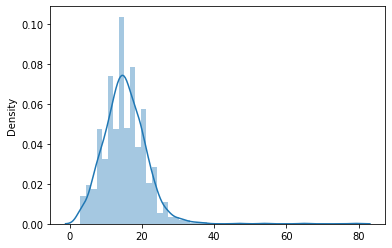

In [36]:
lengths = []
for i in range(len(train_tweet)):
    lengths.append(len(tokenizer.tokenize(train_tweet.text.iloc[i])))
    
sns.distplot(lengths)

C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

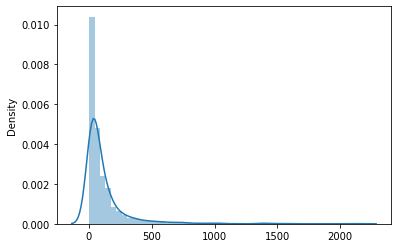

In [18]:
lengths = []
for i in range(len(train_tweet)):
    lengths.append(len(tokenizer.tokenize(train_tweet.reply_text.iloc[i])))
    
sns.distplot(lengths)

C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

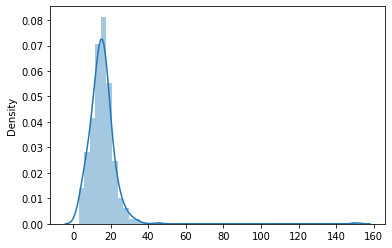

In [19]:
lengths = []
for i in range(len(dev_tweet)):
    lengths.append(len(tokenizer.tokenize(dev_tweet.text.iloc[i])))
    
sns.distplot(lengths)

In [37]:
def generate_seq(tweet, tokenizer, max_len):
    seq = []
    mask = []
    seg = []
    for i in tqdm(range(len(tweet))):
        txt = tweet.iloc[i]
        tokens = tokenizer.tokenize(txt)
        if len(tokens) < max_len:
             padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
        else:
            padded_tokens = tokens[:max_len-1] + ['[SEP]']

        attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
        seg_ids = []
        seg_idx = 0
        for token in padded_tokens:
            seg_ids.append(seg_idx)
            if token == '[SEP]':
                if seg_idx == 1:
                    seg_idx = 0
                else:
                    seg_idx=1
        token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

        seq.append(token_ids)
        mask.append(attn_mask)
        seg.append(seg_ids)
    return seq, mask, seg

In [38]:
train_src_seq, train_src_mask, train_src_seg = generate_seq(train_tweet.text, tokenizer, 256)
train_rp_seq, train_rp_mask, train_rp_seg = generate_seq(train_tweet.reply_text, tokenizer, 512)
dev_src_seq, dev_src_mask, dev_src_seg = generate_seq(dev_tweet.text, tokenizer,256)
dev_rp_seq, dev_rp_mask, dev_rp_seg = generate_seq(dev_tweet.reply_text, tokenizer,512)

100%|███████████████████████████████████████████████████████████████████████████████| 536/536 [00:01<00:00, 279.17it/s]


In [46]:
class RumorClassifier(nn.Module):

    def __init__(self):
        super(RumorClassifier, self).__init__()
        #Instantiating BERT model object 
        self.src_layer = BertModel.from_pretrained('bert-base-uncased')
        self.rp_layer = BertModel.from_pretrained('bert-base-uncased')
        
        self.ffnn = nn.Sequential(nn.Linear(1579,512),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                  nn.Linear(512,128),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )

    def forward(self, src_seq, src_mask, src_seg, rp_seq, rp_mask, rp_seg, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        src_outputs = self.src_layer(src_seq, attention_mask=src_mask,token_type_ids=src_seg, return_dict=True)
        rp_outputs = self.rp_layer(rp_seq, attention_mask=rp_mask,token_type_ids=rp_seg, return_dict=True)
        src_cont_reps = src_outputs.last_hidden_state
        rp_cont_reps = rp_outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        src_cls_rep = src_cont_reps[:, 0]
        rp_cls_rep = rp_cont_reps[:,0]
        
        x = torch.cat((src_cls_rep,rp_cls_rep), dim=1)
        x = torch.cat((x,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        logits = self.ffnn(x)

        return logits

In [40]:
class AdTweetDataset(Data.Dataset):
    def __init__(self, src_seq, src_mask, src_seg, rp_seq, rp_mask, rp_seg, y):
        self.src_seq = torch.tensor(src_seq)
        self.src_mask = torch.tensor(src_mask)
        self.src_seg = torch.tensor(src_seg)
        self.rp_seq = torch.tensor(rp_seq)
        self.rp_mask = torch.tensor(rp_mask)
        self.rp_seg = torch.tensor(rp_seg)
        self.y = torch.tensor(y)
    
    def __len__(self):
        return self.src_seq.shape[0]
    
    def __getitem__(self, idx):
        return self.src_seq[idx],self.src_mask[idx],self.src_seg[idx], self.rp_seq[idx],self.rp_mask[idx],self.rp_seg[idx],self.y[idx], idx

In [41]:
y_train = train_tweet['label']
y_dev = dev_tweet['label']
w_nonr = len(y_train)/(len(y_train)-y_train.sum())
w_r = len(y_train)/(y_train.sum())
weights = []
for l in y_train:
    if l == 0:
        weights.append(w_nonr)
    else:
        weights.append(w_r)
weights = torch.FloatTensor(weights)

In [42]:
torch.manual_seed(42)
train_set = AdTweetDataset(train_src_seq, train_src_mask, train_src_seg,train_rp_seq, train_rp_mask, train_rp_seg,y_train)
dev_set = AdTweetDataset(dev_src_seq, dev_src_mask, dev_src_seg,dev_rp_seq, dev_rp_mask, dev_rp_seg,y_train)

# sampler_s = sp.StratifiedSampler(class_vector=torch.from_numpy(np.array(y_train)), batch_size=64)
train_sampler = Data.WeightedRandomSampler(weights, len(train_set), replacement=True)
train_loader = Data.DataLoader(train_set, sampler=train_sampler,batch_size=16)
# train_loader = Data.DataLoader(train_set,batch_size=64,shuffle=True)
dev_loader = Data.DataLoader(dev_set, batch_size=16, shuffle=False)

In [47]:
# torch.cuda.empty_cache ()
net = RumorClassifier()
# net = net.to(device)

criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_

In [44]:
def get_accuracy_from_logits(logits, labels):
    probs = logits.unsqueeze(-1)
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

def get_f1_from_logits(logits, labels):
    preds = (logits >= 0.5).astype(int)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, pos_label=1, average="binary")
    return f

def get_roc_auc_from_logits(logits, labels):
    preds = (logits >= 0.5).astype(int)
    return roc_auc_score(preds,labels)

def evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    all_log = np.array([])
    all_labels = np.array([])
    with torch.no_grad():
        for src_seq, src_mask, src_seg, rp_seq, rp_mask, rp_seg, labels, idx in dataloader:
            # seq, labels = seq.to(device), labels.to(device)
            stats = np.array(dev_stat)
            stats = torch.tensor(stats[idx]).float()
            #Obtaining the logits from the model
            logits = net(src_seq, src_mask, rp_seq, rp_mask, rp_seg, src_seg, stats)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            # mean_acc += get_accuracy_from_logits(logits, labels)
            
            all_log = np.hstack((all_log, logits.squeeze()))
            all_labels = np.hstack((all_labels, labels.numpy()))
            count += 1
        
        f = get_f1_from_logits(all_log, all_labels)
        roc_auc = get_roc_auc_from_logits(all_log, all_labels)
    return f, roc_auc, mean_loss / count

In [48]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []

for ep in range(20):
    eps.append(ep)
    net.train()
    for it, (src_seq, src_mask, src_seg, rp_seq, rp_mask, rp_seg, labels, idx) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)

        stats = np.array(train_stat)
        stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(src_seq, src_mask, src_seg, rp_seq, rp_mask, rp_seg, stats)
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, roc_auc, dev_loss = evaluate(net, criterion, dev_loader, 'cpu')
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development F1: {}; Development ROCAUC: {}; Development Loss: {}".format(dev_acc, roc_auc, dev_loss))
    torch.save(net.state_dict(), 'D:\\bertcls_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.6991459727287292; Accuracy: 0.375; Time taken (s): 45.84958457946777
Iteration 10 of epoch 0 complete. 
 Loss: 0.6957747340202332; Accuracy: 0.5625; Time taken (s): 473.7372086048126
Iteration 20 of epoch 0 complete. 
 Loss: 0.7030247449874878; Accuracy: 0.25; Time taken (s): 474.47956252098083
Iteration 30 of epoch 0 complete. 
 Loss: 0.6707202196121216; Accuracy: 0.875; Time taken (s): 471.0740931034088
Iteration 40 of epoch 0 complete. 
 Loss: 0.6546711921691895; Accuracy: 0.875; Time taken (s): 474.2898473739624


KeyboardInterrupt: 

### preprocess train dev

In [93]:
train_stat = pd.read_csv('./mean/train_scaled_stat_feat_df.csv')
dev_stat = pd.read_csv('./mean/dev_scaled_stat_feat_df.csv')

train_tweet = pd.read_csv('./mean/train_tweet_df.csv')
dev_tweet = pd.read_csv('./mean/dev_tweet_df.csv')

# train_stat.info()

# dev_stat.info()

train_stat.drop(columns=['Unnamed: 0','label'], inplace=True)
train_stat.head()

dev_stat.drop(columns=['Unnamed: 0','label'], inplace=True)
dev_stat.head()

train_stat.sum()

dev_zero = []
for column in dev_stat.columns:
    if (dev_stat[column] != 0).sum() == 0:
        dev_zero.append(column)
print(dev_zero)

train_zero = []
for column in train_stat.columns:
    if (train_stat[column] != 0).sum() == 0:
        train_zero.append(column)
print(train_zero)

train_stat.drop(columns=train_zero, inplace=True)
dev_stat.drop(columns=dev_zero, inplace=True)

dev_tweet.head()

['reply_contributors', 'reply_following_rate', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'following_rate', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']
['reply_contributors', 'reply_following_rate', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'following_rate', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']


,tweet_id,text,reply_text,label
0,1240727985491193862,covid viru transmit area hot humid world healt...,humid good demonstr virus surviv temperatur hi...,0
1,634943791934406657,marilyn monro jame dean smoke new york citi,icon [SEP] [SEP] yo puedo demostrar que era h...,1
2,1243967693297987584,symptom covid jcinigeria,symptom usual mild gradual common [SEP] infect...,0
3,1233175449980874752,coronaviru wear mask protect covid,thank [SEP],0
4,1245592346344841216,symptom covid let watch new episod q covid know,infect peopl around world believ togeth stop [...,0


In [94]:
train_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579 entries, 0 to 1578
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   reply_question_mark           1579 non-null   float64
 1   reply_favourite_rate          1579 non-null   float64
 2   reply_user_engagement         1579 non-null   float64
 3   reply_possibly_sensitive      1579 non-null   float64
 4   reply_retweet_count           1579 non-null   float64
 5   reply_favorite_count          1579 non-null   float64
 6   reply_mentioned_url_num       1579 non-null   float64
 7   reply_id_num                  1579 non-null   float64
 8   reply_followers_count         1579 non-null   float64
 9   reply_friends_count           1579 non-null   float64
 10  reply_listed_count            1579 non-null   float64
 11  reply_favourites_count        1579 non-null   float64
 12  reply_statuses_count          1579 non-null   float64
 13  rep

In [187]:
a = np.array(train_stat.id_num)
a = np.unique(a)
len(a)

11

In [188]:
b = np.array(dev_stat.id_num)
b = np.unique(b)
len(b)

11

In [189]:
a == b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [190]:
test_stat = pd.read_csv('./knn/test_scaled_stat_feat_df.csv')
test_stat.drop(columns=dev_zero, inplace=True)

c = np.array(test_stat.id_num)
c = np.unique(c)
len(c)

9

In [192]:
count = 0
for i in c:
    if i in a:
        count += 1
print(count)

9


### Fill NaN

In [95]:
# dev_tweet.info()

# train_tweet.info()

dev_tweet.reply_text.fillna('None', inplace=True)
train_tweet.reply_text.fillna('None', inplace=True)
dev_tweet.text.fillna('None', inplace=True)
train_tweet.text.fillna('None', inplace=True)

dev_tweet.info()

# dev_tweet.iloc[0].reply_text

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    536 non-null    int64 
 1   text        536 non-null    object
 2   reply_text  536 non-null    object
 3   label       536 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 16.9+ KB


In [96]:
dev_tweet[dev_tweet.text == 'None' ].label

210    0
220    0
312    0
315    0
331    0
400    0
442    0
Name: label, dtype: int64

### Get Embeddings

In [97]:
for i in tqdm(range(len(dev_tweet))):
    dev_tweet.text.iloc[i] = '[CLS] ' + str(dev_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(dev_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

for i in tqdm(range(len(train_tweet))):
    train_tweet.text.iloc[i] = '[CLS] ' + str(train_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(train_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

dev_tweet.iloc[0].text

  0%|                                                                                          | 0/536 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_89188\2101879647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_tweet.text.iloc[i] = '[CLS] ' + str(dev_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(dev_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
  0%|                                                                                         | 0/1579 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_89188\2101879647.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tweet.text.iloc[i

'[CLS] covid viru transmit area hot humid world health organ [SEP] humid good demonstr virus surviv temperatur high [SEP] mean warm weather good elimin [SEP]'

In [98]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### BERT Embeddings

In [4]:
max_len = 256
dev_tokens = []
train_tokens = []

for i in tqdm(range(len(dev_tweet))):
    txt = dev_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = []
    seg_idx = 0
    for token in padded_tokens:
        seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    token_ids_t = torch.tensor(token_ids).unsqueeze(0) #Shape : [1, 12]
    attn_mask_t = torch.tensor(attn_mask).unsqueeze(0) #Shape : [1, 12]
    seg_ids_t   = torch.tensor(seg_ids).unsqueeze(0) #Shape : [1, 12]
    outputs = bert_model(token_ids_t, attention_mask = attn_mask_t,\
                                  token_type_ids = seg_ids_t, return_dict=True)
    cont_reps = outputs.last_hidden_state
    cls_rep = cont_reps[:, 0]
    dev_tokens.append(cls_rep.detach().numpy())

for i in tqdm(range(len(train_tweet))):
    txt = train_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = [1 if token == '[SEP]' else 0 for token in padded_tokens]
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    token_ids_t = torch.tensor(token_ids).unsqueeze(0)
    attn_mask_t = torch.tensor(attn_mask).unsqueeze(0)
    seg_ids_t   = torch.tensor(seg_ids).unsqueeze(0)
    outputs = bert_model(token_ids_t, attention_mask = attn_mask_t,\
                                  token_type_ids = seg_ids_t, return_dict=True)
    cont_reps = outputs.last_hidden_state
    cls_rep = cont_reps[:, 0]
    train_tokens.append(cls_rep.detach().numpy())

  0%|                                                                                          | 0/536 [00:00<?, ?it/s]


NameError: name 'tokenizer' is not defined

### BERT seq

In [99]:
max_len = 256
dev_seq = []
train_seq = []
dev_mask = []
train_mask = []
dev_seg = []
train_seg = []

for i in tqdm(range(len(dev_tweet))):
    txt = dev_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = []
    seg_idx = 0
    for token in padded_tokens:
        seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
    # seg_ids = [1 if token == '[SEP]' else 0 for token in padded_tokens]
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    
    dev_seq.append(token_ids)
    dev_mask.append(attn_mask)
    dev_seg.append(seg_ids)

for i in tqdm(range(len(train_tweet))):
    txt = train_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = []
    seg_idx = 0
    for token in padded_tokens:
        seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    
    train_seq.append(token_ids)
    train_mask.append(attn_mask)
    train_seg.append(seg_ids)

100%|█████████████████████████████████████████████████████████████████████████████| 1579/1579 [00:05<00:00, 280.07it/s]


### BERT adjustment

In [100]:
class AdTweetDataset(Data.Dataset):
    def __init__(self, seq_, mask_, seg_, y_):
        self.seq = torch.tensor(seq_)
        self.mask = torch.tensor(mask_)
        self.seg = torch.tensor(seg_)
        self.y = torch.tensor(y_)
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx],self.mask[idx],self.seg[idx], self.y[idx], idx

In [101]:
y_train = train_tweet['label']
y_dev = dev_tweet['label']
w_nonr = len(y_train)/(len(y_train)-y_train.sum())
w_r = len(y_train)/(y_train.sum())
weights = []
for l in y_train:
    if l == 0:
        weights.append(w_nonr)
    else:
        weights.append(w_r)
weights = torch.FloatTensor(weights)

In [102]:
torch.manual_seed(42)
train_set = AdTweetDataset(train_seq, train_mask, train_seg,y_train)
dev_set = AdTweetDataset(dev_seq, dev_mask, dev_seg, y_dev)

# sampler_s = sp.StratifiedSampler(class_vector=torch.from_numpy(np.array(y_train)), batch_size=64)
train_sampler = Data.WeightedRandomSampler(weights, len(train_set), replacement=True)
train_loader = Data.DataLoader(train_set, sampler=train_sampler,batch_size=64)
# train_loader = Data.DataLoader(train_set,batch_size=64,shuffle=True)
dev_loader = Data.DataLoader(dev_set, batch_size=64, shuffle=False)

In [103]:
class RumorClassifier(nn.Module):

    def __init__(self):
        super(RumorClassifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        self.ffnn = nn.Sequential(nn.Linear(817,128),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )

    def forward(self, seq_,attn_masks, seg_, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq_, attention_mask = attn_masks,token_type_ids = seg_, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        logits = self.ffnn(x)

        return logits

In [104]:
# torch.cuda.empty_cache ()
net = RumorClassifier()
# net = net.to(device)

criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [105]:
def get_accuracy_from_logits(logits, labels):
    probs = logits.unsqueeze(-1)
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

def get_f1_from_logits(logits, labels):
    preds = (logits >= 0.5).astype(int)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, pos_label=1, average="binary")
    return f

def get_roc_auc_from_logits(logits, labels):
    preds = (logits >= 0.5).astype(int)
    return roc_auc_score(preds,labels)

def evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    all_log = np.array([])
    all_labels = np.array([])
    with torch.no_grad():
        for seq, mask, seg, labels, idx in dataloader:
            # seq, labels = seq.to(device), labels.to(device)
            stats = np.array(dev_stat)
            stats = torch.tensor(stats[idx]).float()
            #Obtaining the logits from the model
            logits = net(seq, mask, seg, stats)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            # mean_acc += get_accuracy_from_logits(logits, labels)
            
            all_log = np.hstack((all_log, logits.squeeze()))
            all_labels = np.hstack((all_labels, labels.numpy()))
            count += 1
        
        f = get_f1_from_logits(all_log, all_labels)
        roc_auc = get_roc_auc_from_logits(all_log, all_labels)
    return f, roc_auc, mean_loss / count

In [106]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []

In [107]:
for ep in range(20):
    eps.append(ep)
    net.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)

        stats = np.array(train_stat)
        stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(seq, mask, seg, stats)
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, roc_auc, dev_loss = evaluate(net, criterion, dev_loader, 'cpu')
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development F1: {}; Development ROCAUC: {}; Development Loss: {}".format(dev_acc, roc_auc, dev_loss))
    torch.save(net.state_dict(), 'D:\\bertcls_{}.dat'.format(ep))

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 201326592 bytes.

### Bert with selected features

In [239]:
with open('feat.pkl','rb') as file:
    feat = pickle.load(file)
selec_train_stat = train_stat.iloc[:,feat>10]
selec_dev_stat = dev_stat.iloc[:,feat>10]

In [240]:
selec_train_stat.shape

(1579, 38)

In [241]:
selec_train_stat.head()

,reply_retweet_count,reply_favorite_count,reply_mentioned_url_num,reply_id_num,reply_followers_count,reply_friends_count,reply_listed_count,reply_favourites_count,reply_statuses_count,reply_has_url,...,statuses_count,has_url,senti_score,truncated,geo_enabled,verified,isweekday,reply_count,has_extended_profile,default_profile
0,-0.035464,-0.032811,1.025336,2.657715,-0.089606,-0.066187,-0.134181,-0.558722,-0.391871,1.378565,...,-0.483678,0.529732,-0.674759,1.047352,0.929638,-0.798728,0.580519,-0.502164,-0.722953,1.392986
1,-0.035464,-0.032904,-0.431897,-0.082064,-0.080291,0.439807,-0.087721,0.369384,0.322511,-0.165996,...,1.771763,0.529732,-0.674759,-0.954789,0.929638,1.251990,0.580519,-0.295325,-0.722953,-0.717882
2,-0.035464,-0.032759,1.025336,0.494732,-0.089944,-0.332350,-0.139497,-0.674989,-0.615587,1.378565,...,-0.589294,0.529732,-0.674759,1.047352,-1.075688,-0.798728,-1.722596,-0.502164,1.383215,1.392986
3,-0.035325,-0.032888,1.025336,-0.947257,-0.086016,0.210712,-0.135568,1.020982,0.715749,1.378565,...,-0.155849,0.529732,-0.674759,1.047352,0.929638,-0.798728,0.580519,-0.450454,1.383215,1.392986
4,-0.035299,-0.032891,-1.313433,0.227697,-0.088478,0.376196,-0.121870,0.326148,1.982894,-1.100361,...,-0.058380,0.529732,-0.674759,-0.954789,-1.075688,-0.798728,-1.722596,0.842289,-0.722953,-0.717882


In [242]:
class RumorClassifier(nn.Module):

    def __init__(self):
        super(RumorClassifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        self.ffnn = nn.Sequential(nn.Linear(806,128),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )

    def forward(self, seq_,attn_masks, seg_, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq_, attention_mask = attn_masks,token_type_ids = seg_, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        logits = self.ffnn(x)

        return logits

In [243]:
def get_accuracy_from_logits(logits, labels):
    probs = logits.unsqueeze(-1)
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

def get_f1_from_logits(logits, labels):
    preds = (logits > 0.5).astype(int)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, pos_label=1, average="binary")
    return f

def get_roc_auc_from_logits(logits, labels):
    preds = (logits > 0.5).astype(int)
    return roc_auc_score(preds,labels)

def evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    all_log = np.array([])
    all_labels = np.array([])
    with torch.no_grad():
        for seq, mask, seg, labels, idx in dataloader:
            # seq, labels = seq.to(device), labels.to(device)
            stats = np.array(selec_train_stat)
            stats = torch.tensor(stats[idx]).float()
            #Obtaining the logits from the model
            logits = net(seq, mask, seg, stats)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            # mean_acc += get_accuracy_from_logits(logits, labels)
            
            all_log = np.hstack((all_log, logits.squeeze()))
            all_labels = np.hstack((all_labels, labels.numpy()))
            count += 1
        
        f = get_f1_from_logits(all_log, all_labels)
        roc_auc = get_roc_auc_from_logits(all_log, all_labels)
    return f, roc_auc, mean_loss / count

In [244]:
y_train = train_tweet['label']
y_dev = dev_tweet['label']
w_nonr = len(y_train)/(len(y_train)-y_train.sum())
w_r = len(y_train)/(y_train.sum())
weights = []
for l in y_train:
    if l == 0:
        weights.append(w_nonr)
    else:
        weights.append(w_r)
weights = torch.FloatTensor(weights)

In [245]:
torch.manual_seed(42)
train_set = AdTweetDataset(train_seq, train_mask, train_seg,y_train)
dev_set = AdTweetDataset(dev_seq, dev_mask, dev_seg, y_dev)

# sampler_s = sp.StratifiedSampler(class_vector=torch.from_numpy(np.array(y_train)), batch_size=64)
train_sampler = Data.WeightedRandomSampler(weights, len(train_set), replacement=True)
train_loader = Data.DataLoader(train_set, sampler=train_sampler,batch_size=64)
# train_loader = Data.DataLoader(train_set,batch_size=64,shuffle=True)
dev_loader = Data.DataLoader(dev_set, batch_size=64, shuffle=False)

In [246]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []

In [248]:
# torch.cuda.empty_cache ()
net = RumorClassifier()
# net = net.to(device)

criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [249]:
for ep in range(20):
    eps.append(ep)
    net.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)

        stats = np.array(selec_train_stat)
        stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(seq, mask, seg, stats)
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, roc_auc, dev_loss = evaluate(net, criterion, dev_loader, 'cpu')
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development F1: {}; Development ROCAUC: {}; Development Loss: {}".format(dev_acc, roc_auc, dev_loss))
    torch.save(net.state_dict(), 'D:\\bertcls_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.6857006549835205; Accuracy: 0.578125; Time taken (s): 146.7471570968628
Iteration 10 of epoch 0 complete. 
 Loss: 0.6718034744262695; Accuracy: 0.71875; Time taken (s): 451.541695356369
Iteration 20 of epoch 0 complete. 
 Loss: 0.6260150074958801; Accuracy: 0.6875; Time taken (s): 384.16609930992126
Development F1: 0.5272727272727272; Development ROCAUC: 0.6587118742302398; Development Loss: 0.6318900982538859
Iteration 0 of epoch 1 complete. 
 Loss: 0.6138072609901428; Accuracy: 0.78125; Time taken (s): 307.5684721469879
Iteration 10 of epoch 1 complete. 
 Loss: 0.500972330570221; Accuracy: 0.859375; Time taken (s): 388.1270651817322
Iteration 20 of epoch 1 complete. 
 Loss: 0.561872661113739; Accuracy: 0.765625; Time taken (s): 380.68222165107727
Development F1: 0.5962732919254659; Development ROCAUC: 0.7030086780318048; Development Loss: 0.5595700740814209
Iteration 0 of epoch 2 complete. 
 Loss: 0.43333330750465393; Accuracy: 0.890625; Tim

KeyboardInterrupt: 

### Optimize Embedding

In [23]:
class RumorEmbedder(nn.Module):

    def __init__(self):
        super(RumorEmbedder, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        self.ffnn = nn.Sequential(nn.Linear(811,512),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                 nn.Linear(512,256)
                                 )

    def forward(self, seq, attn_masks, seg, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq, attention_mask = attn_masks,token_type_ids=seg, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        embs = self.ffnn(x)

        return embs

In [98]:
def cos_sim(a,b):
    norm_a = torch.norm(a, dim=1)
    norm_b = torch.norm(b, dim=0)
    return torch.mm(a,b)/torch.mm(norm_a.unsqueeze(1), norm_b.unsqueeze(0))

class IntraInterLoss(nn.Module):

    def __init__(self):
        super(IntraInterLoss, self).__init__()

    def forward(self, emb, target):
        nr_emb = emb[target==0]
        r_emb = emb[target==1]
        # count_1_1 = r_emb.shape[0]**2
        # count_0_0 = nr_emb.shape[0]**2
        count_0_1 = r_emb.shape[0]*nr_emb.shape[0]
        # r_cos = torch.sum(cos_sim(r_emb, r_emb.T))/float(count_1_1)
        # nr_cos = torch.sum(cos_sim(nr_emb, nr_emb.T))/float(count_0_0)
        r_nr_cos = torch.sum(cos_sim(r_emb, nr_emb.T))/float(count_0_1)
        
        # return r_nr_cos-0.4*r_cos-0.2*nr_co
        return r_nr_cos

In [99]:
from torch.optim import lr_scheduler
dev_loader = Data.DataLoader(dev_set, batch_size=len(dev_set), shuffle=False)
# torch.cuda.empty_cache ()
net = RumorEmbedder()
# net = net.to(device)

criterion = IntraInterLoss()
opti = optim.Adam(net.parameters(), lr = 0.0001)
# scheduler = lr_scheduler.ExponentialLR(opti, gamma=0.7)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [100]:
import time
st = time.time()
for ep in range(20):
    net.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)

        stats = np.array(train_stat)
        stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(seq, mask, seg, stats)
        #Computing loss
        loss = criterion(logits, labels)

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            print("Iteration {} of epoch {} complete. \n Loss: {}; Time taken (s): {}".format(it, ep, loss.item(), (time.time()-st)))
            st = time.time()

    net.eval()
    with torch.no_grad():
        for seq, mask, seg, labels, idx in dev_loader:
            dev_embs = net(seq, mask, seg, torch.FloatTensor(np.array(dev_stat)))
        dev_loss = criterion(dev_embs, labels)
    
    print("Development Loss: {}".format(dev_loss.item()))
    torch.save(net.state_dict(), 'D:\\bertemb_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.5331344604492188; Time taken (s): 38.81303811073303
Iteration 10 of epoch 0 complete. 
 Loss: -0.12910909950733185; Time taken (s): 384.3883762359619
Iteration 20 of epoch 0 complete. 
 Loss: -0.34423840045928955; Time taken (s): 509.495046377182
Development Loss: -0.21523994207382202
Iteration 0 of epoch 1 complete. 
 Loss: -0.34500735998153687; Time taken (s): 303.1614820957184
Iteration 10 of epoch 1 complete. 
 Loss: -0.2748572826385498; Time taken (s): 387.96017479896545
Iteration 20 of epoch 1 complete. 
 Loss: -0.3327857255935669; Time taken (s): 439.9628129005432
Development Loss: -0.22750616073608398
Iteration 0 of epoch 2 complete. 
 Loss: -0.26534950733184814; Time taken (s): 387.5401408672333
Iteration 10 of epoch 2 complete. 
 Loss: -0.3566115200519562; Time taken (s): 537.8501224517822
Iteration 20 of epoch 2 complete. 
 Loss: -0.34135881066322327; Time taken (s): 462.56627917289734
Development Loss: -0.10752232372760773
Iteratio

KeyboardInterrupt: 

### BertEmbedding Test

In [53]:
net = RumorEmbedder()
net.load_state_dict(torch.load('D:\\bertemb_9.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [99]:
dev_loader = Data.DataLoader(dev_set, batch_size=len(dev_set), shuffle=False,sampler=range(0,len(dev_set)))
train_loader = Data.DataLoader(train_set, batch_size=len(train_set), shuffle=False, sampler=range(0,len(train_set)))

In [100]:
net.eval()
with torch.no_grad():
    for seq, mask, seg, labels,idx in train_loader:
        train_embs = net(seq, mask, seg, torch.FloatTensor(np.array(train_stat)))
    for seq, mask, seg, labels, idx in dev_loader:
        dev_embs = net(seq, mask, seg, torch.FloatTensor(np.array(dev_stat)))

In [102]:
r_mean = train_embs[np.array(y_train) == 1].mean(dim=0).numpy()
nr_mean = train_embs[np.array(y_train) == 0].mean(dim=0).numpy()
dev_embs_n = dev_embs.numpy()
dev_preds = []

for emb in dev_embs_n:
    r_sim = np.dot(emb, r_mean)/(np.linalg.norm(emb)*np.linalg.norm(r_mean))
    nr_sim = np.dot(emb, nr_mean)/(np.linalg.norm(emb)*np.linalg.norm(nr_mean))
    if r_sim >= nr_sim:
        dev_preds.append(1)
    else:
        dev_preds.append(0)

p, r, f, _ = precision_recall_fscore_support(y_dev, dev_preds, pos_label=1, average="binary")
print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))
print('Accuracy: {}'.format(accuracy_score(y_dev, dev_preds)))

Precision:0.35964912280701755  Recall:0.7130434782608696  F1:0.47813411078717205
Accuracy: 0.6660447761194029


In [103]:
r_mean = train_embs[np.array(y_train) == 1].mean(dim=0).numpy()
nr_mean = train_embs[np.array(y_train) == 0].mean(dim=0).numpy()
dev_embs_n = dev_embs.numpy()
dev_preds = []

for emb in train_embs.numpy():
    r_sim = np.dot(emb, r_mean)/(np.linalg.norm(emb)*np.linalg.norm(r_mean))
    nr_sim = np.dot(emb, nr_mean)/(np.linalg.norm(emb)*np.linalg.norm(nr_mean))
    if r_sim >= nr_sim:
        dev_preds.append(1)
    else:
        dev_preds.append(0)

p, r, f, _ = precision_recall_fscore_support(y_train, dev_preds, pos_label=1, average="binary")
print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))
print('Accuracy: {}'.format(accuracy_score(y_train, dev_preds)))

Precision:0.3890675241157556  Recall:0.7610062893081762  F1:0.5148936170212767
Accuracy: 0.7112096263457884


In [97]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embs.numpy(), y_train)

predictions = knn.predict(dev_embs_n)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.5463917525773195  Recall:0.4608695652173913  F1:0.5
Accuracy: 0.8022388059701493


In [107]:
import pickle
with open('X_train.pkl','rb') as file:
    X_train = pickle.load(file)
with open('X_dev.pkl','rb') as file:
    X_dev = pickle.load(file)
with open('y_dev.pkl','rb') as file:
    y_dev = pickle.load(file)
with open('y_train.pkl','rb') as file:
    y_train = pickle.load(file)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

predictions = knn.predict(X_dev)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.6732673267326733  Recall:0.6181818181818182  F1:0.6445497630331753
Accuracy: 0.8563218390804598


In [98]:
lr = LogisticRegression(max_iter=100)
lr.fit(train_embs.numpy(), y_train)

predictions = lr.predict(dev_embs_n)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.6666666666666666  Recall:0.06956521739130435  F1:0.12598425196850394
Accuracy: 0.792910447761194


C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
r_mean

array([ 0.559523  , -0.6694411 ,  0.6386693 , -0.3082815 , -1.4688318 ,
        1.0080024 ,  0.76538223,  1.5122892 , -0.85284615,  1.7891976 ,
       -1.4008505 , -0.55482763,  1.8608657 , -0.6717017 ,  0.97310126,
        0.5818697 , -0.5390343 , -0.7755241 ,  1.9045625 , -0.26476654,
       -1.3056165 , -0.9074661 ,  0.7634458 , -1.5461605 ,  0.08976556,
       -0.8494065 , -0.8777184 , -1.0230728 ,  0.3525765 , -1.5808235 ,
        0.01667575, -0.1495756 , -0.3053692 ,  0.07764101, -1.1683062 ,
        0.7895137 , -0.09378773, -0.17215891, -0.15668851,  0.42977983,
        0.4158164 , -1.5737258 ,  1.8172727 ,  1.4243525 ,  1.8285083 ,
        0.71199876, -0.9187279 ,  1.1941608 ,  0.565277  ,  0.28214428,
        1.4069462 ,  1.2998426 ,  1.0016237 , -0.82209605, -0.50618243,
        0.05480868,  1.6530193 , -0.52838504,  0.8456729 , -1.1414135 ,
       -0.13572106,  0.576234  ,  0.7270736 , -1.4084289 ], dtype=float32)

In [67]:
nr_mean

array([ 0.5737024 , -0.6759854 ,  0.6507191 , -0.32405192, -1.4975203 ,
        1.0036894 ,  0.78646857,  1.5012347 , -0.87575895,  1.8210517 ,
       -1.4066744 , -0.5509191 ,  1.885839  , -0.68972784,  0.9726847 ,
        0.5760501 , -0.54722756, -0.80475795,  1.9094418 , -0.26871154,
       -1.3065656 , -0.9108496 ,  0.78440595, -1.5575368 ,  0.07096983,
       -0.8725201 , -0.853683  , -1.0237498 ,  0.34915003, -1.5788484 ,
        0.02422947, -0.13966322, -0.32549387,  0.08283487, -1.1725831 ,
        0.7983685 , -0.07583883, -0.16052043, -0.15137553,  0.4250438 ,
        0.41498375, -1.5853176 ,  1.8458185 ,  1.4217794 ,  1.8454164 ,
        0.7082451 , -0.94747126,  1.2044528 ,  0.55465084,  0.29615617,
        1.405537  ,  1.2859378 ,  1.0131048 , -0.8556225 , -0.49518442,
        0.05648269,  1.654872  , -0.5226128 ,  0.84434843, -1.1529379 ,
       -0.14024371,  0.5695921 ,  0.74909246, -1.4219875 ], dtype=float32)

### Text Only Bert

In [18]:
class TextRumorClassifier(nn.Module):

    def __init__(self):
        super(TextRumorClassifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        self.ffnn = nn.Sequential(nn.Linear(768,128),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )

    def forward(self, seq, attn_masks, seg):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq, attention_mask = attn_masks, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        # x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        logits = self.ffnn(cls_rep)

        return logits

In [35]:
net = TextRumorClassifier()
# net = net.to(device)

criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def text_evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for seq, mask, seg, labels, idx in dataloader:
            # seq, labels = seq.to(device), labels.to(device)
            # stats = np.array(train_stat.iloc[:,1:])
            # stats = torch.tensor(stats[idx]).float()
            #Obtaining the logits from the model
            logits = net(seq, mask, seg)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

In [27]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []

In [36]:
for ep in range(20):
    eps.append(ep)
    net.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(train_loader):

        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)

        # stats = np.array(train_stat.iloc[:,1:])
        # stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(seq, mask, seg)

        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()


    dev_acc, dev_loss = text_evaluate(net, criterion, dev_loader, 'cpu')
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development Accuracy: {}; Development Loss: {}".format(dev_acc, dev_loss))
    torch.save(net.state_dict(), 'D:\\bertcls_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.6802356839179993; Accuracy: 0.671875; Time taken (s): 81.13227605819702
Iteration 10 of epoch 0 complete. 
 Loss: 0.5898295044898987; Accuracy: 0.78125; Time taken (s): 299.43943309783936
Iteration 20 of epoch 0 complete. 
 Loss: 0.5761324763298035; Accuracy: 0.75; Time taken (s): 298.0222783088684
Development Accuracy: 0.7715277671813965; Development Loss: 0.5319444206025865
Iteration 0 of epoch 1 complete. 
 Loss: 0.5774604678153992; Accuracy: 0.734375; Time taken (s): 220.4582164287567
Iteration 10 of epoch 1 complete. 
 Loss: 0.4819682836532593; Accuracy: 0.8125; Time taken (s): 296.9613416194916
Iteration 20 of epoch 1 complete. 
 Loss: 0.45131972432136536; Accuracy: 0.796875; Time taken (s): 297.24166321754456
Development Accuracy: 0.7996528148651123; Development Loss: 0.43302328056759304
Iteration 0 of epoch 2 complete. 
 Loss: 0.4024360477924347; Accuracy: 0.8125; Time taken (s): 225.989727973938
Iteration 10 of epoch 2 complete. 
 Los

### Text Only Test

In [37]:
text_model = TextRumorClassifier()
text_model.load_state_dict(torch.load('D:\\bertcls_14.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [38]:
test_tweet = pd.read_csv('./sep_data/test_tweet_df.csv')
test_stat = pd.read_csv('./sep_data/test_stat_feat_df.csv')

In [39]:
test_tweet.text.fillna('', inplace=True)
test_tweet.reply_text.fillna('', inplace=True)
for i in tqdm(range(len(test_tweet))):
    test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip()

  0%|                                                                                          | 0/558 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_6104\3174842241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip()
100%|████████████████████████████████████████████████████████████████████████████████| 558/558 [00:08<00:00, 68.94it/s]


In [40]:
max_len = 256
test_seq = []
test_mask = []
test_seg = []

for i in tqdm(range(len(test_tweet))):
    try:
        txt = test_tweet.text.iloc[i]
        tokens = tokenizer.tokenize(txt)
        if len(tokens) < max_len:
             padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
        else:
            padded_tokens = tokens[:max_len-1] + ['[SEP]']
        attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
        seg_ids = []
        seg_idx = 0
        for token in padded_tokens:
            seg_ids.append(seg_idx)
            if token == '[SEP]':
                seg_idx += 1
        token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

        test_seq.append(token_ids)
        test_mask.append(attn_mask)
        test_seg.append(seg_ids)
    except:
        print(i)

100%|███████████████████████████████████████████████████████████████████████████████| 558/558 [00:02<00:00, 270.06it/s]


In [45]:
text_model.eval()
preds = []
with torch.no_grad():
    for i in tqdm(range(len(test_seq))):
        seq = torch.tensor(test_seq[i]).unsqueeze(0)
        mask = torch.tensor(test_mask[i]).unsqueeze(0)
        seg = torch.tensor(test_seg[i]).unsqueeze(0)
        
        preds.append(text_model(seq,mask,seg))

100%|████████████████████████████████████████████████████████████████████████████████| 558/558 [02:19<00:00,  4.01it/s]


In [46]:
for i in range(len(preds)):
    preds[i] = preds[i].squeeze().squeeze()

for i in range(len(preds)):
    preds[i] = preds[i].numpy()

predictions = preds[0]
for i in range(1,len(preds)):
    predictions = np.hstack((predictions,preds[i]))

In [47]:
pred_dict = {'Id':[i for i in range(len(predictions))], 'Predicted':predictions}
pred_df = DataFrame(pred_dict)
pred_df.Predicted = pred_df.Predicted.apply(lambda x: 1 if x > 0.5 else 0)
pred_df.to_csv('predictions.csv', index=False)

### adjust Bert

In [82]:
model = RumorClassifier()
# print(model)
model.load_state_dict(torch.load('D:\\./bert_feat/bertcls_16.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [54]:
ad_loader = Data.DataLoader(dev_set,batch_size=1)

In [55]:
criterion = nn.BCELoss()
opti = optim.Adam(model.parameters(), lr = 2e-5)

In [32]:
model.eval()
ad_seq = []
ad_mask = []
ad_seg = []
ad_label = []
ad_stat = []
with torch.no_grad():
    for i, (seq, mask, seg, label, idx) in enumerate(ad_loader):
        stats = np.array(dev_stat)
        stats = torch.tensor(stats[idx]).float().unsqueeze(0)
        logits = model(seq, mask, seg, stats)
        pred = (logits > 0.5)
        if pred[0][0].int() != label[0]:
            ad_seq.append(seq.squeeze().numpy())
            ad_mask.append(mask.squeeze().numpy())
            ad_seg.append(seg.squeeze().numpy())
            ad_label.append(label[0])
            ad_stat.append(stats.squeeze().numpy())

In [57]:
ad_set = AdTweetDataset(ad_seq, ad_mask, ad_seg, ad_label)
ad_loader = Data.DataLoader(ad_set, batch_size=len(ad_set), shuffle=False)

In [92]:
for ep in range(5):
    # eps.append(ep)
    model.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(dev_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)

        stats = np.array(dev_stat)
        stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = model(seq, mask, seg, stats)
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())
        print(loss.requires_grad)

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        acc = get_accuracy_from_logits(logits, labels)
        print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
        st = time.time()

        
    # dev_acc, roc_auc, dev_loss = evaluate(net, criterion, dev_loader, 'cpu')
    # t_loss.append(loss.item())
    # d_loss.append(dev_loss)
    # print("Development F1: {}; Development ROCAUC: {}; Development Loss: {}".format(dev_acc, roc_auc, dev_loss))
    # torch.save(net.state_dict(), 'D:\\bertcls_{}.dat'.format(ep))

True
Iteration 0 of epoch 0 complete. 
 Loss: 0.2970641851425171; Accuracy: 0.921875; Time taken (s): 78.44341588020325


KeyboardInterrupt: 

In [ ]:
dev_acc, roc_auc, dev_loss = evaluate(model, criterion, dev_loader, 'cpu')
print("Development F1: {}; Development ROCAUC: {}; Development Loss: {}".format(dev_acc, roc_auc, dev_loss))

### BERT TEST

In [76]:
model = RumorClassifier()
# print(model)
model.load_state_dict(torch.load('D:\\./bert_feat/bertcls_16.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [77]:
criterion = nn.BCELoss()
dev_acc, roc_auc, dev_loss = evaluate(model, criterion, dev_loader, 'cpu')
print("Development F1: {}; Development ROCAUC: {}; Development Loss: {}".format(dev_acc, roc_auc, dev_loss))

Development F1: 0.8727272727272727; Development ROCAUC: 0.9351010938017899; Development Loss: 0.19777061986840433


In [21]:
test_tweet = pd.read_csv('./sep_data/test_tweet_df.csv')
# test_stat = pd.read_csv('./test_scaled_stat_feat_df.csv')
test_stat = pd.read_csv('test_stat.csv')

test_stat.drop(columns=train_zero, inplace=True)
# test_stat.drop(columns=['tweet_id'], inplace=True)
test_stat

test_tweet.text.fillna('', inplace=True)
test_tweet.reply_text.fillna('', inplace=True)

for i in tqdm(range(len(test_tweet))):
    test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

max_len = 256
test_seq = []
test_mask = []
test_seg = []

for i in tqdm(range(len(test_tweet))):
    txt = test_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = []
    seg_idx = 0
    for token in padded_tokens:
        seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

    test_seq.append(token_ids)
    test_mask.append(attn_mask)
    test_seg.append(seg_ids)

class TestTweetDataset(Data.Dataset):
    def __init__(self, seq, mask, seg, stat):
        self.seq = torch.tensor(seq).long()
        self.mask = torch.tensor(mask).long()
        self.seg = torch.tensor(seg).long()
        self.stat = torch.tensor(stat).float()
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx],self.mask[idx],self.seg[idx], self.stat[idx]

test_set = TestTweetDataset(test_seq, test_mask, test_seg, np.array(test_stat))
test_loader = Data.DataLoader(test_set, batch_size=64, shuffle=False, sampler=range(0,len(test_seq)))

  0%|                                                                                          | 0/558 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_54996\245015903.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
100%|███████████████████████████████████████████████████████████████████████████████| 558/558 [00:03<00:00, 174.31it/s]


In [22]:
model.eval()
preds = []
test_stat = np.array(test_stat)
with torch.no_grad():
    for i, (seq, mask, seg, stat) in tqdm(enumerate(test_loader)):
        preds.append(model(seq, mask, seg, stat))

9it [04:22, 29.14s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    558 non-null    int64 
 1   text        556 non-null    object
 2   reply_text  545 non-null    object
dtypes: int64(1), object(2)
memory usage: 13.2+ KB


  0%|                                                                                          | 0/558 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_35580\413825232.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
100%|████████████████████████████████████████████████████████████████████████████████| 558/558 [00:09<00:00, 61.45it/s]


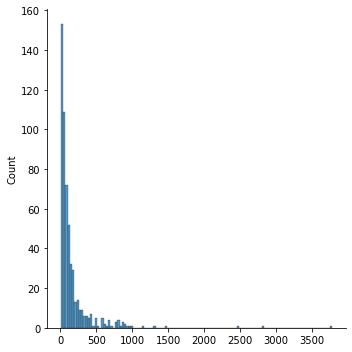

In [24]:
# test_tweet = pd.read_csv('./sep_data/test_tweet_df.csv')
# test_stat = pd.read_csv('./sep_data/test_scaled_stat_feat_df.csv')

# test_stat.drop(columns=train_zero, inplace=True)
# test_stat.drop(columns=['tweet_id'], inplace=True)

# test_tweet.info()
# test_tweet.text.fillna('', inplace=True)
# test_tweet.reply_text.fillna('', inplace=True)

# for i in tqdm(range(len(test_tweet))):
#     test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
    
# lengths = []
# for i in range(len(test_tweet)):
#     lengths.append(len(tokenizer.tokenize(test_tweet.text.iloc[i])))

# sns.displot(lengths)

In [23]:
for i in range(len(preds)):
    preds[i] = preds[i].squeeze().squeeze()

for i in range(len(preds)):
    preds[i] = preds[i].numpy()

predictions = preds[0]
for i in range(1,len(preds)):
    predictions = np.hstack((predictions,preds[i]))

In [24]:
predictions

array([0.01190638, 0.01281527, 0.01233704, 0.01136634, 0.01165775,
       0.01286908, 0.9905624 , 0.99211615, 0.01227905, 0.01249662,
       0.9916726 , 0.9914404 , 0.011853  , 0.9910746 , 0.0120134 ,
       0.01155867, 0.01300371, 0.01206443, 0.01240571, 0.01212292,
       0.01195382, 0.01292421, 0.01241092, 0.9926002 , 0.01231042,
       0.01233201, 0.01257519, 0.01371817, 0.01458283, 0.9924723 ,
       0.01267439, 0.99213374, 0.989906  , 0.01198859, 0.0121442 ,
       0.0117514 , 0.01193468, 0.01181973, 0.01167796, 0.01428581,
       0.01255713, 0.9921572 , 0.01286034, 0.01401622, 0.01166129,
       0.01265707, 0.01362337, 0.04113172, 0.01429767, 0.01260714,
       0.01158412, 0.01218689, 0.99227715, 0.08342714, 0.01163215,
       0.08122139, 0.9924638 , 0.01121922, 0.01277406, 0.01285836,
       0.0134752 , 0.9926334 , 0.01186364, 0.0116148 , 0.07416357,
       0.01208622, 0.9869065 , 0.01691747, 0.0122215 , 0.01188298,
       0.01201664, 0.01221892, 0.01204539, 0.99264175, 0.01203

In [25]:
pred_dict = {'Id':[i for i in range(len(predictions))], 'Predicted':predictions}
pred_df = DataFrame(pred_dict)

pred_df.Predicted = pred_df.Predicted.apply(lambda x: 1 if x > 0.5 else 0)

pred_df.to_csv('predictions.csv', index=False)

### Create Train and Dev Dataset

In [34]:
class BertEmb(RumorClassifier):
    def __init__(self):
        super().__init__()
    
    def forward(self, seq_,attn_masks, seg_, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq_, attention_mask = attn_masks,token_type_ids = seg_, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        x = torch.cat((cls_rep,stats),dim=1)

        return x

In [35]:
bert_model = BertEmb()
bert_model.load_state_dict(torch.load('D:\\bertcls_15.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [36]:
dev_loader = Data.DataLoader(dev_set, batch_size=len(dev_set), shuffle=False,sampler=range(0,len(dev_set)))
train_loader = Data.DataLoader(train_set, batch_size=len(train_set), shuffle=False, sampler=range(0,len(train_set)))

bert_model.eval()

with torch.no_grad():
    for seq, mask, seg, labels,idx in train_loader:
        train_data = bert_model(seq, mask, seg, torch.FloatTensor(np.array(train_stat)))
    for seq, mask, seg, labels, idx in dev_loader:
        dev_data = bert_model(seq, mask, seg, torch.FloatTensor(np.array(dev_stat)))
    
train_data = train_data.numpy()
dev_data = dev_data.numpy()

In [37]:
columns = [i for i in range(768)] + list(train_stat.columns)
X_train = DataFrame(train_data, columns=columns)
X_dev = DataFrame(dev_data, columns=columns)
y_train = train_tweet['label']
y_dev = dev_tweet['label']

In [38]:
X_train.to_csv('knn_X_train.csv')
X_dev.to_csv('knn_X_dev.csv')
y_train.to_csv('y_train.csv')
y_dev.to_csv('y_dev.csv')

### Create last layer Train Dev

In [38]:
class Extractor(RumorClassifier):

    def __init__(self):
        super().__init__()

    def forward(self, seq_,attn_masks, seg_, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq_, attention_mask = attn_masks,token_type_ids = seg_, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        x = self.ffnn[0](x)
        x = self.ffnn[1](x)
        x = self.ffnn[2](x)
        x = self.ffnn[3](x)
        x = self.ffnn[4](x)
        x = self.ffnn[5](x)

        return x

In [39]:
model = Extractor()
model.load_state_dict(torch.load('D:\\bertcls_16.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [40]:
dev_loader = Data.DataLoader(dev_set, batch_size=len(dev_set), shuffle=False,sampler=range(0,len(dev_set)))
train_loader = Data.DataLoader(train_set, batch_size=len(train_set), shuffle=False, sampler=range(0,len(train_set)))

model.eval()

with torch.no_grad():
    for seq, mask, seg, labels,idx in train_loader:
        train_data = model(seq, mask, seg, torch.FloatTensor(np.array(train_stat)))
    for seq, mask, seg, labels, idx in dev_loader:
        dev_data = model(seq, mask, seg, torch.FloatTensor(np.array(dev_stat)))
    
train_data = train_data.numpy()
dev_data = dev_data.numpy()

In [41]:
X_train = DataFrame(train_data)
X_dev = DataFrame(dev_data)
X_train.to_csv('X_train_last.csv')
X_dev.to_csv('X_dev_last.csv')

### Create dense last layer train dev

In [82]:
class DenseExtractor(RumorClassifier):

    def __init__(self):
        super().__init__()

    def forward(self, seq_,attn_masks, seg_, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq_, attention_mask = attn_masks,token_type_ids = seg_, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        x = self.ffnn[0](x)
        x = self.ffnn[1](x)
        x = self.ffnn[2](x)
        x = self.ffnn[3](x)

        return x

In [83]:
model = DenseExtractor()
model.load_state_dict(torch.load('D:\\bertcls_16.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [84]:
dev_loader = Data.DataLoader(dev_set, batch_size=len(dev_set), shuffle=False,sampler=range(0,len(dev_set)))
train_loader = Data.DataLoader(train_set, batch_size=len(train_set), shuffle=False, sampler=range(0,len(train_set)))

model.eval()

with torch.no_grad():
    for seq, mask, seg, labels,idx in train_loader:
        train_data = model(seq, mask, seg, torch.FloatTensor(np.array(train_stat)))
    for seq, mask, seg, labels, idx in dev_loader:
        dev_data = model(seq, mask, seg, torch.FloatTensor(np.array(dev_stat)))
    
train_data = train_data.numpy()
dev_data = dev_data.numpy()

In [85]:
X_train = DataFrame(train_data)
X_dev = DataFrame(dev_data)
X_train.to_csv('X_train_dlast.csv')
X_dev.to_csv('X_dev_dlast.csv')

### Create Test

In [39]:
test_tweet = pd.read_csv('./knn/test_tweet_df.csv')
test_stat = pd.read_csv('./knn/test_scaled_stat_feat_df.csv')

test_stat.drop(columns=train_zero, inplace=True)
test_stat.drop(columns=['tweet_id'], inplace=True)
test_stat

test_tweet.text.fillna('', inplace=True)
test_tweet.reply_text.fillna('', inplace=True)

for i in tqdm(range(len(test_tweet))):
    test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

max_len = 256
test_seq = []
test_mask = []
test_seg = []

for i in tqdm(range(len(test_tweet))):
    try:
        txt = test_tweet.text.iloc[i]
        tokens = tokenizer.tokenize(txt)
        if len(tokens) < max_len:
             padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
        else:
            padded_tokens = tokens[:max_len-1] + ['[SEP]']
        attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
        seg_ids = []
        seg_idx = 0
        for token in padded_tokens:
            seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
        token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

        test_seq.append(token_ids)
        test_mask.append(attn_mask)
        test_seg.append(seg_ids)
    except:
        print(i)

class TestTweetDataset(Data.Dataset):
    def __init__(self, seq, mask, seg, stat):
        self.seq = torch.tensor(seq).long()
        self.mask = torch.tensor(mask).long()
        self.seg = torch.tensor(seg).long()
        self.stat = torch.tensor(stat).float()
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx],self.mask[idx],self.seg[idx], self.stat[idx]

test_set = TestTweetDataset(test_seq, test_mask, test_seg, np.array(test_stat))
test_loader = Data.DataLoader(test_set, batch_size=len(test_set), shuffle=False, sampler=range(0,len(test_seq)))

bert_model.eval()

with torch.no_grad():
    for seq, mask, seg, labels in test_loader:
        test_data = bert_model(seq, mask, seg, torch.FloatTensor(np.array(test_stat)))
        
columns = [i for i in range(768)] + list(train_stat.columns)
X_test = DataFrame(test_data, columns=columns)
X_test.to_csv('knn_X_test.csv',index=False)

  0%|                                                                                          | 0/558 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_50348\2041090260.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
100%|███████████████████████████████████████████████████████████████████████████████| 558/558 [00:01<00:00, 291.85it/s]


### Create Last layer test

In [43]:
test_tweet = pd.read_csv('./sep_data/test_tweet_df.csv')
test_stat = pd.read_csv('./sep_data/test_scaled_stat_feat_df.csv')

test_stat.drop(columns=train_zero, inplace=True)
test_stat.drop(columns=['tweet_id'], inplace=True)
test_stat

test_tweet.text.fillna('', inplace=True)
test_tweet.reply_text.fillna('', inplace=True)

for i in tqdm(range(len(test_tweet))):
    test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

max_len = 256
test_seq = []
test_mask = []
test_seg = []

for i in tqdm(range(len(test_tweet))):
    try:
        txt = test_tweet.text.iloc[i]
        tokens = tokenizer.tokenize(txt)
        if len(tokens) < max_len:
             padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
        else:
            padded_tokens = tokens[:max_len-1] + ['[SEP]']
        attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
        seg_ids = []
        seg_idx = 0
        for token in padded_tokens:
            seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
        token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

        test_seq.append(token_ids)
        test_mask.append(attn_mask)
        test_seg.append(seg_ids)
    except:
        print(i)

class TestTweetDataset(Data.Dataset):
    def __init__(self, seq, mask, seg, stat):
        self.seq = torch.tensor(seq).long()
        self.mask = torch.tensor(mask).long()
        self.seg = torch.tensor(seg).long()
        self.stat = torch.tensor(stat).float()
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx],self.mask[idx],self.seg[idx], self.stat[idx]

test_set = TestTweetDataset(test_seq, test_mask, test_seg, np.array(test_stat))
test_loader = Data.DataLoader(test_set, batch_size=len(test_set), shuffle=False, sampler=range(0,len(test_seq)))

model.eval()

with torch.no_grad():
    for seq, mask, seg, labels in test_loader:
        test_data = model(seq, mask, seg, torch.FloatTensor(np.array(test_stat)))
        
X_test = DataFrame(test_data)
X_test.to_csv('X_test_last.csv',index=False)

  0%|                                                                                          | 0/558 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_33448\651624481.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
100%|███████████████████████████████████████████████████████████████████████████████| 558/558 [00:01<00:00, 282.40it/s]


### Create dense last layer test

In [86]:
test_tweet = pd.read_csv('./sep_data/test_tweet_df.csv')
test_stat = pd.read_csv('./sep_data/test_scaled_stat_feat_df.csv')

test_stat.drop(columns=train_zero, inplace=True)
test_stat.drop(columns=['tweet_id'], inplace=True)
test_stat

test_tweet.text.fillna('', inplace=True)
test_tweet.reply_text.fillna('', inplace=True)

for i in tqdm(range(len(test_tweet))):
    test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

max_len = 256
test_seq = []
test_mask = []
test_seg = []

for i in tqdm(range(len(test_tweet))):
    try:
        txt = test_tweet.text.iloc[i]
        tokens = tokenizer.tokenize(txt)
        if len(tokens) < max_len:
             padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
        else:
            padded_tokens = tokens[:max_len-1] + ['[SEP]']
        attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
        seg_ids = []
        seg_idx = 0
        for token in padded_tokens:
            seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
        token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

        test_seq.append(token_ids)
        test_mask.append(attn_mask)
        test_seg.append(seg_ids)
    except:
        print(i)

class TestTweetDataset(Data.Dataset):
    def __init__(self, seq, mask, seg, stat):
        self.seq = torch.tensor(seq).long()
        self.mask = torch.tensor(mask).long()
        self.seg = torch.tensor(seg).long()
        self.stat = torch.tensor(stat).float()
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx],self.mask[idx],self.seg[idx], self.stat[idx]

test_set = TestTweetDataset(test_seq, test_mask, test_seg, np.array(test_stat))
test_loader = Data.DataLoader(test_set, batch_size=len(test_set), shuffle=False, sampler=range(0,len(test_seq)))

model.eval()

with torch.no_grad():
    for seq, mask, seg, labels in test_loader:
        test_data = model(seq, mask, seg, torch.FloatTensor(np.array(test_stat)))
        
X_test = DataFrame(test_data)
X_test.to_csv('X_test_dlast.csv',index=False)

  0%|                                                                                          | 0/558 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_33448\1663756482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
100%|███████████████████████████████████████████████████████████████████████████████| 558/558 [00:02<00:00, 258.12it/s]


### LightGBM

In [4]:
X_train = pd.read_csv('./embs/X_train.csv').iloc[:,1:]
X_dev = pd.read_csv('./embs/X_dev.csv').iloc[:,1:]
y_train = pd.read_csv('./embs/y_train.csv')['label']
y_dev = pd.read_csv('./embs/y_dev.csv')['label']

In [5]:
train_stat = pd.read_csv('./user_rumor/train_scaled_stat_feat_df.csv')
dev_stat = pd.read_csv('./user_rumor/dev_scaled_stat_feat_df.csv')
y_train = train_stat.label
y_dev = dev_stat.label
train_stat.drop(columns=['Unnamed: 0','label'], inplace=True)
dev_stat.drop(columns=['Unnamed: 0','label'], inplace=True)

dev_zero = []
for column in dev_stat.columns:
    if (dev_stat[column] != 0).sum() == 0:
        dev_zero.append(column)
print(dev_zero)

train_zero = []
for column in train_stat.columns:
    if (train_stat[column] != 0).sum() == 0:
        train_zero.append(column)
print(train_zero)

train_stat.drop(columns=train_zero, inplace=True)
dev_stat.drop(columns=dev_zero, inplace=True)

['reply_contributors', 'reply_following_rate', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'following_rate', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'isSeen', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']
['reply_contributors', 'reply_following_rate', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'following_rate', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'isSeen', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']


In [6]:
X_train = pd.concat([X_train.iloc[:,:768],train_stat],axis=1)
X_dev = pd.concat([X_dev.iloc[:,:768],dev_stat],axis=1)
# X_train = pd.concat([X_train,X_dev], axis=0)
# y_train = np.array(y_train)
# y_dev = np.array(y_dev)
# y_train = np.hstack((y_train,y_dev))
# X_train = X_train[['279','723','157','12']]
# X_dev = X_dev[['279','723','157','12']]

In [7]:
X_dev

,0,1,2,3,4,5,6,7,8,9,...,is_quote_status,rumour_ratio,geo_enabled,verified,isweekday,reply_count,is_translation_enabled,has_extended_profile,default_profile,default_profile_image
0,-0.880192,-0.728196,1.612426,-0.083484,-0.113172,0.452923,0.435032,0.663716,0.943430,-0.618001,...,-0.152745,-0.552737,0.929638,-0.798728,0.580519,-0.450454,-0.36541,1.383215,-0.717882,-0.050395
1,0.365451,-0.090752,-0.071123,0.078542,0.198850,0.441863,0.747412,0.650095,-0.752969,-1.011699,...,-0.152745,2.181632,-1.075688,-0.798728,-1.722596,-0.398744,-0.36541,-0.722953,-0.717882,-0.050395
2,-0.946925,-0.742187,1.534366,-0.135325,0.048500,0.449157,0.402589,0.690342,1.120352,-0.407501,...,6.546840,-0.552737,0.929638,-0.798728,-1.722596,-0.347035,-0.36541,1.383215,1.392986,-0.050395
3,-0.808552,-0.651042,1.627361,-0.175387,0.082574,0.383813,0.487550,0.674342,1.123464,-0.665059,...,6.546840,-0.552737,0.929638,-0.798728,0.580519,-0.450454,-0.36541,-0.722953,-0.717882,-0.050395
4,-0.871665,-0.674740,1.594515,-0.179282,0.045840,0.511247,0.509051,0.510217,1.136090,-0.513790,...,-0.152745,-0.552737,0.929638,-0.798728,0.580519,-0.191906,-0.36541,1.383215,-0.717882,-0.050395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,-0.922309,-0.675224,1.620308,-0.023053,0.123072,0.376571,0.522146,0.555349,1.009547,-0.552752,...,-0.152745,-0.552737,0.929638,-0.798728,0.580519,-0.036776,-0.36541,-0.722953,-0.717882,-0.050395
532,-0.857517,-0.619240,1.600955,-0.076643,-0.062739,0.256190,0.414631,0.614217,1.010060,-0.529119,...,-0.152745,-0.552737,0.929638,-0.798728,0.580519,-0.502164,-0.36541,1.383215,1.392986,-0.050395
533,0.425518,0.307572,-0.115605,0.245290,0.114922,0.330689,0.355133,0.445820,-0.913724,-0.837191,...,-0.152745,2.181632,0.929638,-0.798728,0.580519,-0.502164,-0.36541,1.383215,-0.717882,-0.050395
534,-0.887692,-0.770682,1.643489,-0.279817,0.027623,0.427354,0.398448,0.485090,0.789924,-0.602365,...,-0.152745,-0.552737,-1.075688,-0.798728,0.580519,-0.450454,-0.36541,1.383215,-0.717882,-0.050395


In [60]:
len(y_train)

2115

In [288]:
from sklearn.decomposition import PCA
pca_mle = PCA(n_components=0.999)
pca_mle = pca_mle.fit(X_train)
X_train = pca_mle.transform(X_train)
X_dev = pca_mle.transform(X_dev)

In [25]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_dev = poly.transform(X_dev)

In [173]:
# sm = SVMSMOTE()
# X_train,y_train = sm.fit_resample(X_train, y_train)

In [85]:
X_train.shape

(2115, 811)

In [8]:
from sklearn.model_selection import train_test_split
# train,val,y,y_val = train_test_split(X_train,
#                                         y_train,
#                                         train_size=0.66,
#                                         stratify=y_train,
#                                         random_state=42)
def gbm_objective(trial):
    n_estimators = trial.suggest_int('n_estimators',1,2001,1)
    learning_rate = trial.suggest_loguniform('learning_rate',1e-5,1.0)
    max_depth = trial.suggest_int('max_depth',2,101,1)
    num_leaves = trial.suggest_int('num_leaves',2,101,1)
    subsample_freq = trial.suggest_int('subsample_freq',2,101,1)
    min_child_samples = trial.suggest_int('min_child_samples',2,101,1)
    min_child_weight = trial.suggest_float('min_child_weight',0.0001,1.0,log=False)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.5,1.0,log=False)
    subsample = trial.suggest_float('subsample',0.5,1.0,log=False)
    reg_alpha = trial.suggest_float('reg_alpha',0.0,1.0,log=False)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,1.0,log=False)
    min_split_gain = trial.suggest_float('min_split_gain',0.0,1.0,log=False)
    max_bin = trial.suggest_int('max_bin',20,512,1)
    
    
    
    classifier_obj = lgb.LGBMClassifier(objective = 'binary',
                                       n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                        num_leaves=num_leaves,
                                       min_child_samples=min_child_samples,
                                        min_child_weight=min_child_weight,
                                       colsample_bytree=colsample_bytree,
                                       subsample=subsample,
                                        subsample_freq=subsample_freq,
                                       reg_alpha=reg_alpha,
                                       reg_lambda=reg_lambda,
                                       min_split_gain=min_split_gain,
                                       max_bin=max_bin,
                                       random_state=42)
    
    classifier_obj.fit(X_train,y_train)
    predictions = classifier_obj.predict(X_dev).astype(int)
    if np.sum(predictions) == 0:
        predictions[0] = 1
    # return roc_auc_score(predictions,y_dev)
    p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")
    return f
    # return roc_auc_score(predictions,y_dev)

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(gbm_objective, n_trials=500,n_jobs=-1)

[I 2022-04-29 17:23:27,361] A new study created in memory with name: no-name-4079f0da-7114-458c-a2b4-88defae809e9
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-04-29 17:23:33,706] Trial 5 finished with value: 0.8416289592760181 and parameters: {'n_estimators': 295, 'learning_rate': 0.053403462987347605, 'max_depth': 21, 'num_leaves': 32, 'subsample_freq': 77, 'min_child_samples': 66, 'min_child_weight': 0.08315484001741716, 'colsample_bytree': 0.8876538615493601, 'subsample': 0.7752454285982444, 'reg_alpha': 0.5440080737387932, 'reg_lambda': 0.9474004529837832, 'min_split_gain': 0.7591969806831362, 'max_bin': 445}. Best is trial 5 with value: 0.8416289592760181.
[I 2022-04-29 17:23:36,392] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 325, 'learn

In [11]:
print(study.best_params)
print(study.best_value)
print(study.best_trial)

{'n_estimators': 1927, 'learning_rate': 0.02313577620248878, 'max_depth': 59, 'num_leaves': 76, 'subsample_freq': 82, 'min_child_samples': 94, 'min_child_weight': 0.3729095275429155, 'colsample_bytree': 0.9929783555957562, 'subsample': 0.6706692086565339, 'reg_alpha': 0.19712027793013448, 'reg_lambda': 0.6125816463318349, 'min_split_gain': 0.4232032048727287, 'max_bin': 245}
0.8778280542986426
FrozenTrial(number=391, values=[0.8778280542986426], datetime_start=datetime.datetime(2022, 4, 29, 17, 37, 43, 537760), datetime_complete=datetime.datetime(2022, 4, 29, 17, 39, 14, 937650), params={'n_estimators': 1927, 'learning_rate': 0.02313577620248878, 'max_depth': 59, 'num_leaves': 76, 'subsample_freq': 82, 'min_child_samples': 94, 'min_child_weight': 0.3729095275429155, 'colsample_bytree': 0.9929783555957562, 'subsample': 0.6706692086565339, 'reg_alpha': 0.19712027793013448, 'reg_lambda': 0.6125816463318349, 'min_split_gain': 0.4232032048727287, 'max_bin': 245}, distributions={'n_estimator

In [10]:
params = study.best_params
gbm = lgb.LGBMClassifier(**params,random_state=42,objective='binary')
gbm.fit(X_train,y_train)
# gbm.fit(train,y)
predictions = gbm.predict(X_dev)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.9150943396226415  Recall:0.8434782608695652  F1:0.8778280542986426
Accuracy: 0.9496268656716418


In [13]:
X_test = pd.read_csv('./embs/X_test.csv').iloc[:,1:]
test_stat = pd.read_csv('./user_rumor/test_scaled_stat_feat_df.csv')
test_stat.drop(columns=train_zero, inplace=True)
test_stat.drop(columns=['tweet_id'], inplace=True)
X_test = pd.concat([X_test.iloc[:,:768],test_stat],axis=1)

# X_test = X_test[['279','723','157','12']]
# X_test = poly.transform(X_test)

In [183]:
gbm.booster_.save_model('./models/bert_lgbm.txt')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

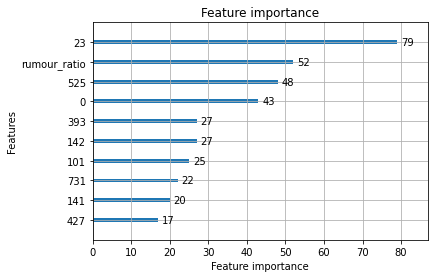

In [15]:
lgb.plot_importance(gbm,max_num_features=10)

In [16]:
predictions = gbm.predict(X_test)
pred_dict = {'Id':[i for i in range(len(predictions))], 'Predicted':predictions}
pred_df = DataFrame(pred_dict)

pred_df.Predicted = pred_df.Predicted.apply(lambda x: 1 if x >= 0.5 else 0)

pred_df.to_csv('predictions.csv', index=False)

In [17]:
sum(predictions)

111

### LGBM with stat

In [18]:
train_stat = pd.read_csv('./knn/train_scaled_stat_feat_df.csv')
dev_stat = pd.read_csv('./knn/dev_scaled_stat_feat_df.csv')
y_train = train_stat.label
y_dev = dev_stat.label
train_stat.drop(columns=['Unnamed: 0','label'], inplace=True)
dev_stat.drop(columns=['Unnamed: 0','label'], inplace=True)

dev_zero = []
for column in dev_stat.columns:
    if (dev_stat[column] != 0).sum() == 0:
        dev_zero.append(column)
print(dev_zero)

train_zero = []
for column in train_stat.columns:
    if (train_stat[column] != 0).sum() == 0:
        train_zero.append(column)
print(train_zero)

train_stat.drop(columns=train_zero, inplace=True)
dev_stat.drop(columns=dev_zero, inplace=True)

['reply_contributors', 'reply_following_rate', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'following_rate', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']
['reply_contributors', 'reply_following_rate', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'following_rate', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']


In [19]:
train_stat

,reply_question_mark,reply_favourite_rate,reply_user_engagement,reply_possibly_sensitive,reply_retweet_count,reply_favorite_count,reply_mentioned_url_num,reply_id_num,reply_followers_count,reply_friends_count,...,truncated,is_quote_status,geo_enabled,verified,isweekday,reply_count,is_translation_enabled,has_extended_profile,default_profile,default_profile_image
0,-0.637413,-0.484737,-0.406657,-0.140574,-0.035470,-0.032817,1.021969,2.659457,-0.089604,-0.065896,...,1.047352,-0.152745,0.929638,-0.798728,0.580519,-0.502164,-0.365410,-0.722953,1.392986,-0.050395
1,-0.637413,0.006288,0.078341,-0.140574,-0.035470,-0.032910,-0.433716,-0.081569,-0.080289,0.440051,...,-0.954789,-0.152745,0.929638,1.251990,0.580519,-0.295325,2.736649,-0.722953,-0.717882,-0.050395
2,-0.637413,-0.564240,-0.617326,-0.140574,-0.035470,-0.032765,1.021969,0.495489,-0.089942,-0.332034,...,1.047352,-0.152745,-1.075688,-0.798728,-1.722596,-0.502164,-0.365410,1.383215,1.392986,-0.050395
3,-0.637413,0.880494,0.919720,-0.140574,-0.035330,-0.032894,1.021969,-0.947156,-0.086014,0.210977,...,1.047352,-0.152745,0.929638,-0.798728,0.580519,-0.450454,-0.365410,1.383215,1.392986,-0.050395
4,-0.149084,0.124205,1.547914,-0.140574,-0.035304,-0.032897,-1.314316,0.228332,-0.088476,0.376446,...,-0.954789,-0.152745,-1.075688,-0.798728,-1.722596,0.842289,-0.365410,-0.722953,-0.717882,-0.050395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,1.120572,-0.565339,-0.579052,-0.140574,-0.035470,-0.032920,1.021969,-0.947156,-0.089284,-0.086588,...,-0.954789,-0.152745,0.929638,-0.798728,0.580519,-0.243615,-0.365410,1.383215,-0.717882,-0.050395
1575,-0.517550,-0.264201,1.403069,-0.140574,-0.035457,-0.032887,-1.183615,-0.094684,-0.087471,-0.144767,...,-0.954789,-0.152745,-1.075688,1.251990,0.580519,0.583740,-0.365410,1.383215,-0.717882,-0.050395
1576,-0.197916,0.341992,1.655589,-0.140574,-0.035470,-0.032920,1.021969,-0.947156,-0.089258,-0.200990,...,1.047352,-0.152745,0.929638,-0.798728,-1.722596,-0.243615,-0.365410,-0.722953,1.392986,-0.050395
1577,-0.637413,-0.302501,-0.225564,-0.140574,-0.035470,-0.032907,0.415434,-0.225834,-0.089776,-0.009336,...,-0.954789,-0.152745,0.929638,1.251990,0.580519,-0.347035,2.736649,-0.722953,-0.717882,-0.050395


In [20]:
def gbm_objective(trial):
    n_estimators = trial.suggest_int('n_estimators',1,2001,1)
    learning_rate = trial.suggest_loguniform('learning_rate',1e-5,1.0)
    max_depth = trial.suggest_int('max_depth',2,101,1)
    num_leaves = trial.suggest_int('num_leaves',2,101,1)
    subsample_freq = trial.suggest_int('subsample_freq',2,101,1)
    min_child_samples = trial.suggest_int('min_child_samples',2,101,1)
    min_child_weight = trial.suggest_float('min_child_weight',0.0001,1.0,log=False)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.5,1.0,log=False)
    subsample = trial.suggest_float('subsample',0.5,1.0,log=False)
    reg_alpha = trial.suggest_float('reg_alpha',0.0,1.0,log=False)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,1.0,log=False)
    min_split_gain = trial.suggest_float('min_split_gain',0.0,1.0,log=False)
    max_bin = trial.suggest_int('max_bin',20,512,1)
    
    
    
    classifier_obj = lgb.LGBMClassifier(objective = 'binary',
                                       n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                        num_leaves=num_leaves,
                                       min_child_samples=min_child_samples,
                                        min_child_weight=min_child_weight,
                                       colsample_bytree=colsample_bytree,
                                       subsample=subsample,
                                        subsample_freq=subsample_freq,
                                       reg_alpha=reg_alpha,
                                       reg_lambda=reg_lambda,
                                       min_split_gain=min_split_gain,
                                       max_bin=max_bin,
                                       random_state=42)
    
    classifier_obj.fit(train_stat,y_train)
    predictions = classifier_obj.predict(dev_stat).astype(int)
    if np.sum(predictions) == 0:
        predictions[0] = 1
    p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")
    return f
    # return roc_auc_score(predictions,y_dev)

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(gbm_objective, n_trials=500,n_jobs=-1)

[I 2022-04-29 19:14:19,172] A new study created in memory with name: no-name-ab73ebd3-3dc7-46b8-8ef4-cc9fa9d884f0
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-04-29 19:14:19,601] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 126, 'learning_rate': 1.855386605597094e-05, 'max_depth': 15, 'num_leaves': 20, 'subsample_freq': 20, 'min_child_samples': 77, 'min_child_weight': 0.002006696919547652, 'colsample_bytree': 0.7540467112830727, 'subsample': 0.9989095374123133, 'reg_alpha': 0.7874091666348386, 'reg_lambda': 0.5746821781906013, 'min_split_gain': 0.7827241889366765, 'max_bin': 107}. Best is trial 3 with value: 0.0.
[I 2022-04-29 19:14:19,950] Trial 0 finished with value: 0.46078431372549017 and parameters: {'n_estimators': 481, 'learning_rate': 0

In [22]:
print(study.best_params)
print(study.best_value)
print(study.best_trial)

{'n_estimators': 1607, 'learning_rate': 0.44108578969384654, 'max_depth': 66, 'num_leaves': 14, 'subsample_freq': 60, 'min_child_samples': 60, 'min_child_weight': 0.8858753589740475, 'colsample_bytree': 0.7067036321810866, 'subsample': 0.5946472807674162, 'reg_alpha': 0.04037140591094407, 'reg_lambda': 0.6242279538914698, 'min_split_gain': 0.46749625805283335, 'max_bin': 283}
0.5581395348837209
FrozenTrial(number=400, values=[0.5581395348837209], datetime_start=datetime.datetime(2022, 4, 29, 19, 15, 59, 320907), datetime_complete=datetime.datetime(2022, 4, 29, 19, 16, 2, 138305), params={'n_estimators': 1607, 'learning_rate': 0.44108578969384654, 'max_depth': 66, 'num_leaves': 14, 'subsample_freq': 60, 'min_child_samples': 60, 'min_child_weight': 0.8858753589740475, 'colsample_bytree': 0.7067036321810866, 'subsample': 0.5946472807674162, 'reg_alpha': 0.04037140591094407, 'reg_lambda': 0.6242279538914698, 'min_split_gain': 0.46749625805283335, 'max_bin': 283}, distributions={'n_estimato

In [24]:
params = study.best_params
gbm = lgb.LGBMClassifier(**params,random_state=42)
gbm.fit(train_stat,y_train)
predictions = gbm.predict(dev_stat)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.6  Recall:0.5217391304347826  F1:0.5581395348837209
Accuracy: 0.8227611940298507


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

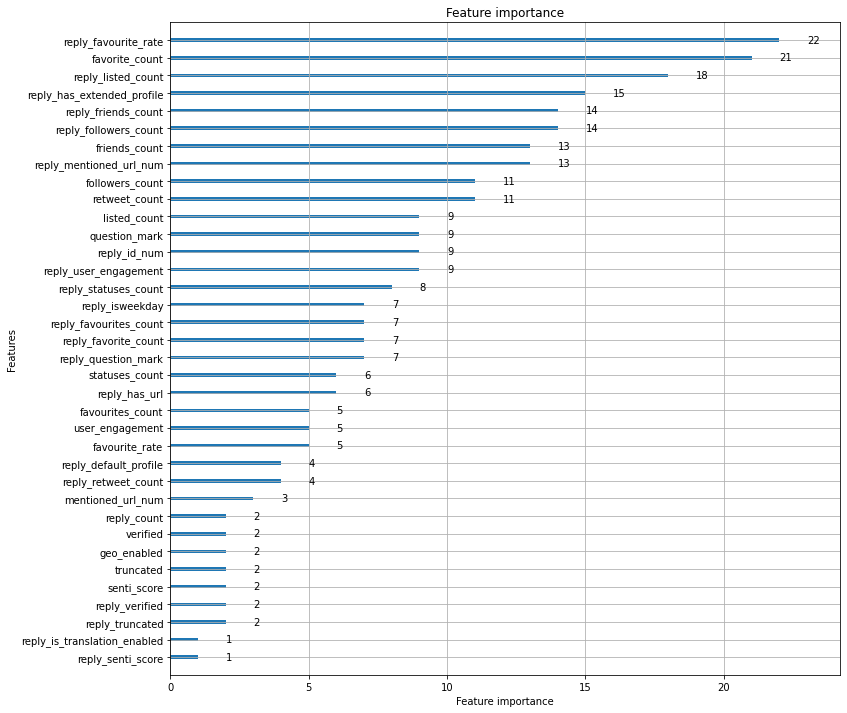

In [27]:
plt.rcParams['figure.figsize'] = (12,12)
lgb.plot_importance(gbm,max_num_features=41)

In [223]:
# gbm = lgb.LGBMClassifier(random_state=42,objective = 'binary')
# gbm._Booster = lgb.Booster(model_file='./models/stat_lgbm.txt')
# gbm.fit(train_stat,y_train)
# feat_import = gbm.feature_importances_

In [28]:
feat_import = gbm.feature_importances_

In [29]:
import pickle
with open('feat.pkl','wb') as file:
    pickle.dump(feat_import,file)
feat_import

array([ 7, 22,  9,  0,  4,  7, 13,  9, 14, 14, 18,  7,  8,  6,  1,  2,  0,
        0,  2,  7,  1, 15,  4,  0,  9,  5,  5,  0, 11, 21,  3,  0, 11, 13,
        9,  5,  6,  0,  2,  2,  0,  2,  2,  0,  2,  0,  0,  0,  0])

In [32]:
a = np.array(train_stat.columns)
a[feat_import==0]

array(['reply_possibly_sensitive', 'reply_is_quote_status',
       'reply_geo_enabled', 'reply_default_profile_image',
       'possibly_sensitive', 'id_num', 'has_url', 'is_quote_status',
       'isweekday', 'is_translation_enabled', 'has_extended_profile',
       'default_profile', 'default_profile_image'], dtype=object)

In [30]:
np.sum(feat_import != 0)

36

In [237]:
gbm.booster_.save_model('./models/stat_lgbm.txt')

### Test XGBoost

In [6]:
X_train = pd.read_csv('X_train.csv').iloc[:,1:]
X_dev = pd.read_csv('X_dev.csv').iloc[:,1:]
y_train = pd.read_csv('y_train.csv')['label']
y_dev = pd.read_csv('y_dev.csv')['label']

In [121]:
def xgb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators',1,2001,1)
    learning_rate = trial.suggest_loguniform('learning_rate',1e-5,1.0)
    max_depth = trial.suggest_int('max_depth',2,101,1)
    num_leaves = trial.suggest_int('num_leaves',2,101,1)
    subsample_freq = trial.suggest_int('subsample_freq',2,101,1)
    min_child_samples = trial.suggest_int('min_child_samples',2,101,1)
    min_child_weight = trial.suggest_float('min_child_weight',0.0001,1.0,log=False)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.5,1.0,log=False)
    subsample = trial.suggest_float('subsample',0.5,1.0,log=False)
    reg_alpha = trial.suggest_float('reg_alpha',0.0,1.0,log=False)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,1.0,log=False)
    min_split_gain = trial.suggest_float('min_split_gain',0.0,1.0,log=False)
    gamma = trial.suggest_float('gamma',1e-10,1e10,log=True)
    
    
    
    classifier_obj = xgb.XGBClassifier(objective = 'binary:logistic',
                                       use_label_encoder=False,
                                       n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                        num_leaves=num_leaves,
                                       min_child_samples=min_child_samples,
                                        min_child_weight=min_child_weight,
                                       colsample_bytree=colsample_bytree,
                                       subsample=subsample,
                                        subsample_freq=subsample_freq,
                                       reg_alpha=reg_alpha,
                                       reg_lambda=reg_lambda,
                                       min_split_gain=min_split_gain,
                                       gamma=gamma,
                                       random_state=42)
    
    classifier_obj.fit(X_train,y_train)
    predictions = classifier_obj.predict(X_dev).astype(int)
    if np.sum(predictions) == 0:
        predictions[0] = 1
    p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")
    return f

In [122]:
study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective, n_trials=500,n_jobs=-1)

[I 2022-04-26 18:05:40,023] A new study created in memory with name: no-name-830bcc04-a3d3-41ca-9366-4852340396e2
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas i

KeyboardInterrupt: 

C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-04-26 18:07:21,451] Trial 4 finished with value: 0.8292682926829269 and parameters: {'n_estimators': 1281, 'learning_rate': 0.033316035832599296, 'max_depth': 82, 'num_leaves': 97, 'subsample_freq': 46, 'min_child_samples': 90, 'min_child_weight': 0.6999806200039214, 'colsample_bytree': 0.6040846201029152, 'subsample': 0.5744681131604437, 'reg_alpha': 0.8780727064116903, 'reg_lambda': 0.9615203101807313, 'min_split_gain': 0.6049674154690284, 'gamma': 8.228642375880809e-05}. Best is trial 4 with value: 0.8292682926829269.
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future ve

0       0
1       0
2       0
3       0
4       1
       ..
1574    0
1575    1
1576    0
1577    0
1578    0
Name: label, Length: 1579, dtype: int64

C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-04-26 18:07:36,911] Trial 6 finished with value: 0.8115942028985508 and parameters: {'n_estimators': 1380, 'learning_rate': 1.3023786961867032e-05, 'max_depth': 60, 'num_leaves': 101, 'subsample_freq': 85, 'min_child_samples': 65, 'min_child_weight': 0.9424399478794093, 'colsample_bytree': 0.8899301433364941, 'subsample': 0.5193399548138653, 'reg_alpha': 0.8974309225043583, 'reg_lambda': 0.5240809617344979, 'min_split_gain': 0.5103011415058677, 'gamma': 0.10740083353245783}. Best is trial 4 with value: 0.8292682926829269.


### Test RF

In [3]:
def RFobjective(trial):
    n_estimator = trial.suggest_int('n_estimators',1,2001,1)
    max_depth = trial.suggest_int('max_depth',2,101,1)
    max_features = trial.suggest_int('max_features',1,811,1)
    min_samples_split = trial.suggest_int('min_samples_split',2,100,1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,100,1)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease',0.0,2.0,log=False)
    classifier_obj = RandomForestClassifier(n_estimators=n_estimator,
                                            max_depth=max_depth,
                                            max_features=max_features,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf,
                                            min_impurity_decrease=min_impurity_decrease,
                                            random_state=42)
    classifier_obj.fit(X_train,y_train)
    predictions = classifier_obj.predict(X_dev).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")
    return f

In [4]:
study = optuna.create_study(direction='maximize')
study.optimize(RFobjective, n_trials=500,n_jobs=-1)

[I 2022-04-26 18:21:06,059] A new study created in memory with name: no-name-38510529-f0eb-402a-b0d3-7cc7a5a40bde
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-04-26 18:21:10,245] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 84, 'max_depth': 98, 'max_features': 53, 'min_samples_split': 84, 'min_samples_leaf': 80, 'min_impurity_decrease': 1.7305976764887663}. Best is trial 6 with value: 0.0.
C:\Users\trist\anaconda3\envs\Pytorch\lib

In [5]:
print(study.best_params)
print(study.best_value)
print(study.best_trial)

{'n_estimators': 882, 'max_depth': 15, 'max_features': 2, 'min_samples_split': 50, 'min_samples_leaf': 22, 'min_impurity_decrease': 0.09644452379792022}
0.8715596330275228
FrozenTrial(number=183, values=[0.8715596330275228], datetime_start=datetime.datetime(2022, 4, 26, 18, 34, 10, 252741), datetime_complete=datetime.datetime(2022, 4, 26, 18, 34, 27, 445240), params={'n_estimators': 882, 'max_depth': 15, 'max_features': 2, 'min_samples_split': 50, 'min_samples_leaf': 22, 'min_impurity_decrease': 0.09644452379792022}, distributions={'n_estimators': IntUniformDistribution(high=2001, low=1, step=1), 'max_depth': IntUniformDistribution(high=101, low=2, step=1), 'max_features': IntUniformDistribution(high=811, low=1, step=1), 'min_samples_split': IntUniformDistribution(high=100, low=2, step=1), 'min_samples_leaf': IntUniformDistribution(high=100, low=1, step=1), 'min_impurity_decrease': UniformDistribution(high=2.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id

In [6]:
params = study.best_params
rf = RandomForestClassifier(**params,random_state=42)
rf.fit(X_train,y_train)
predictions = rf.predict(X_dev)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.9223300970873787  Recall:0.8260869565217391  F1:0.8715596330275228
Accuracy: 0.9477611940298507


In [7]:
X_test = pd.read_csv('X_test.csv')

predictions = rf.predict(X_test)
pred_dict = {'Id':[i for i in range(len(predictions))], 'Predicted':predictions}
pred_df = DataFrame(pred_dict)

pred_df.Predicted = pred_df.Predicted.apply(lambda x: 1 if x > 0.5 else 0)

pred_df.to_csv('predictions.csv', index=False)

### LGBM test with last layer output

In [34]:
X_train = pd.read_csv('X_train_dlast.csv').iloc[:,1:]
X_dev = pd.read_csv('X_dev_dlast.csv').iloc[:,1:]
y_train = pd.read_csv('y_train.csv')['label']
y_dev = pd.read_csv('y_dev.csv')['label']

In [35]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_dev = poly.fit_transform(X_dev)

from sklearn.decomposition import PCA
pca_mle = PCA(n_components=0.99999)
pca_mle = pca_mle.fit(X_train)
X_train = pca_mle.transform(X_train)
X_dev = pca_mle.transform(X_dev)

In [154]:
sm = SVMSMOTE()
X_train,y_train = sm.fit_resample(X_train, y_train)

In [30]:
X_train.shape

(1579, 113)

In [36]:
def gbm_objective(trial):
    n_estimators = trial.suggest_int('n_estimators',1,2001,1)
    learning_rate = trial.suggest_loguniform('learning_rate',1e-5,1.0)
    max_depth = trial.suggest_int('max_depth',2,101,1)
    num_leaves = trial.suggest_int('num_leaves',2,101,1)
    subsample_freq = trial.suggest_int('subsample_freq',2,101,1)
    min_child_samples = trial.suggest_int('min_child_samples',2,101,1)
    min_child_weight = trial.suggest_float('min_child_weight',0.0001,1.0,log=False)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.5,1.0,log=False)
    subsample = trial.suggest_float('subsample',0.5,1.0,log=False)
    reg_alpha = trial.suggest_float('reg_alpha',0.0,1.0,log=False)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,1.0,log=False)
    min_split_gain = trial.suggest_float('min_split_gain',0.0,1.0,log=False)
    max_bin = trial.suggest_int('max_bin',20,512,1)
    
    # k_neighbors = trial.suggest_int('k_neighbors',2,20,1)
    # sm = SVMSMOTE(k_neighbors=k_neighbors,random_state=42)
    # up_X, up_y = sm.fit_resample(X_train,y_train)
    
    classifier_obj = lgb.LGBMClassifier(objective = 'binary',
                                       n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                        num_leaves=num_leaves,
                                       min_child_samples=min_child_samples,
                                        min_child_weight=min_child_weight,
                                       colsample_bytree=colsample_bytree,
                                       subsample=subsample,
                                        subsample_freq=subsample_freq,
                                       reg_alpha=reg_alpha,
                                       reg_lambda=reg_lambda,
                                       min_split_gain=min_split_gain,
                                        # class_weight='balanced',
                                       max_bin=max_bin,
                                       random_state=42)
    
    classifier_obj.fit(X_train,y_train)
    predictions = classifier_obj.predict(X_dev).astype(int)
    if np.sum(predictions) == 0:
        predictions[0] = 1
    # p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")
    # return f
    return roc_auc_score(predictions,y_dev)

In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(gbm_objective, n_trials=500,n_jobs=-1)

[I 2022-04-27 15:23:08,221] A new study created in memory with name: no-name-b7a4d622-b4f6-404e-8b71-ba01632d6d5d
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-04-27 15:23:08,421] Trial 9 finished with value: 0.3925233644859813 and parameters: {'n_estimators': 9, 'learning_rate': 0.044894043029836204, 'max_depth': 6, 'num_leaves': 59, 'subsample_freq': 8, 'min_child_samples': 72, 'min_child_weight': 0.7584483125896189, 'colsample_bytree': 0.6657019872903115, 'subsample': 0.5186420548614407, 'reg_alpha': 0.7621802490246931, 'reg_lambda': 0.6188415709189239, 'min_split_gain': 0.5095584072712579, 'max_bin': 444}. Best is trial 9 with value: 0.3925233644859813.
[I 2022-04-27 15:23:08,507] Trial 8 finished with value: 0.3925233644859813 and parameters: {'n_estimators': 2

In [39]:
print(study.best_params)
print(study.best_value)
print(study.best_trial)

{'n_estimators': 1644, 'learning_rate': 0.3982067052602072, 'max_depth': 11, 'num_leaves': 56, 'subsample_freq': 60, 'min_child_samples': 43, 'min_child_weight': 0.28981435285708923, 'colsample_bytree': 0.515408417329552, 'subsample': 0.7465145073662653, 'reg_alpha': 0.7384779806037071, 'reg_lambda': 0.7874015602717819, 'min_split_gain': 0.37410998991629224, 'max_bin': 469}
0.9459174311926606
FrozenTrial(number=317, values=[0.9459174311926606], datetime_start=datetime.datetime(2022, 4, 27, 15, 25, 12, 963040), datetime_complete=datetime.datetime(2022, 4, 27, 15, 25, 16, 211220), params={'n_estimators': 1644, 'learning_rate': 0.3982067052602072, 'max_depth': 11, 'num_leaves': 56, 'subsample_freq': 60, 'min_child_samples': 43, 'min_child_weight': 0.28981435285708923, 'colsample_bytree': 0.515408417329552, 'subsample': 0.7465145073662653, 'reg_alpha': 0.7384779806037071, 'reg_lambda': 0.7874015602717819, 'min_split_gain': 0.37410998991629224, 'max_bin': 469}, distributions={'n_estimators'

In [40]:
params = study.best_params
gbm = lgb.LGBMClassifier(**params,random_state=42,objective='binary')
# sm = SVMSMOTE(k_neighbors=6,random_state=42)
# up_X, up_y = sm.fit_resample(X_train,y_train)
gbm.fit(X_train,y_train)
predictions = gbm.predict(X_dev)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.94  Recall:0.8173913043478261  F1:0.8744186046511627
Accuracy: 0.9496268656716418


In [18]:
X_test = pd.read_csv('X_test_dlast.csv')
poly = PolynomialFeatures(2)
X_test = poly.fit_transform(X_test)
X_test = pca_mle.transform(X_test)

predictions = gbm.predict(X_test)
pred_dict = {'Id':[i for i in range(len(predictions))], 'Predicted':predictions}
pred_df = DataFrame(pred_dict)

pred_df.Predicted = pred_df.Predicted.apply(lambda x: 1 if x > 0.5 else 0)

pred_df.to_csv('predictions.csv', index=False)

In [ ]:
gbm.booster_.save_model('./models/bert_last_lgbm.txt')

### XGB test with last layer

In [72]:
X_train = pd.read_csv('X_train_last.csv').iloc[:,1:]
X_dev = pd.read_csv('X_dev_last.csv').iloc[:,1:]
y_train = pd.read_csv('y_train.csv')['label']
y_dev = pd.read_csv('y_dev.csv')['label']

In [74]:
def xgb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators',1,2001,1)
    learning_rate = trial.suggest_loguniform('learning_rate',1e-5,1.0)
    max_depth = trial.suggest_int('max_depth',2,101,1)
    num_leaves = trial.suggest_int('num_leaves',2,101,1)
    subsample_freq = trial.suggest_int('subsample_freq',2,101,1)
    min_child_samples = trial.suggest_int('min_child_samples',2,101,1)
    min_child_weight = trial.suggest_float('min_child_weight',0.0001,1.0,log=False)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.5,1.0,log=False)
    subsample = trial.suggest_float('subsample',0.5,1.0,log=False)
    reg_alpha = trial.suggest_float('reg_alpha',0.0,1.0,log=False)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,1.0,log=False)
    min_split_gain = trial.suggest_float('min_split_gain',0.0,1.0,log=False)
    gamma = trial.suggest_float('gamma',1e-10,1e10,log=True)
    
    
    
    classifier_obj = xgb.XGBClassifier(objective = 'binary:logistic',
                                       use_label_encoder=False,
                                       n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                        num_leaves=num_leaves,
                                       min_child_samples=min_child_samples,
                                        min_child_weight=min_child_weight,
                                       colsample_bytree=colsample_bytree,
                                       subsample=subsample,
                                        subsample_freq=subsample_freq,
                                       reg_alpha=reg_alpha,
                                       reg_lambda=reg_lambda,
                                       min_split_gain=min_split_gain,
                                       gamma=gamma,
                                       random_state=42)
    
    classifier_obj.fit(X_train,y_train)
    predictions = classifier_obj.predict(X_dev).astype(int)
    if np.sum(predictions) == 0:
        predictions[0] = 1
    p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")
    return f

In [75]:
study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective, n_trials=500,n_jobs=-1)

[I 2022-04-26 20:02:29,994] A new study created in memory with name: no-name-cf59d9b2-956d-41c6-bff2-004aa5702cd2
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-04-26 20:02:30,518] Trial 7 finished with value: 0.8365384615384615 and parameters: {'n_estimators': 75, 'learning_rate': 0.7198930798191839, 'max_depth': 49, 'num_leaves': 36, 'subsample_freq': 38, 'min_child_samples': 67, 'min_child_weight': 0.6531237733379582, 'colsample_bytree': 0.6026045650683329, 'subsample': 0.99

In [252]:
params = study.best_params
gbm = xgb.XGBClassifier(**params,random_state=42)
gbm.fit(X_train,y_train)
predictions = gbm.predict(X_dev)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=0, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:22:32] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "min_child_samples", "min_split_gain", "num_leaves", "subsample_freq" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:22:32] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision:0.9346846846846847  Recall:0.9857482185273159  F1:0.9595375722543351
Accuracy: 0.9347014925373134


In [ ]:
X_test = pd.read_csv('X_test_last.csv')

predictions = gbm.predict(X_test)
pred_dict = {'Id':[i for i in range(len(predictions))], 'Predicted':predictions}
pred_df = DataFrame(pred_dict)

pred_df.Predicted = pred_df.Predicted.apply(lambda x: 1 if x > 0.5 else 0)

pred_df.to_csv('predictions.csv', index=False)

### RF test with last layer

In [78]:
X_train = pd.read_csv('X_train_last.csv').iloc[:,1:]
X_dev = pd.read_csv('X_dev_last.csv').iloc[:,1:]
y_train = pd.read_csv('y_train.csv')['label']
y_dev = pd.read_csv('y_dev.csv')['label']

In [79]:
def RFobjective(trial):
    n_estimator = trial.suggest_int('n_estimators',1,2001,1)
    max_depth = trial.suggest_int('max_depth',2,101,1)
    max_features = trial.suggest_int('max_features',1,64,1)
    min_samples_split = trial.suggest_int('min_samples_split',2,100,1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,100,1)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease',0.0,2.0,log=False)
    classifier_obj = RandomForestClassifier(n_estimators=n_estimator,
                                            max_depth=max_depth,
                                            max_features=max_features,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf,
                                            min_impurity_decrease=min_impurity_decrease,
                                            random_state=42)
    classifier_obj.fit(X_train,y_train)
    predictions = classifier_obj.predict(X_dev).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")
    return f

In [80]:
study = optuna.create_study(direction='maximize')
study.optimize(RFobjective, n_trials=500,n_jobs=-1)

[I 2022-04-26 20:21:28,179] A new study created in memory with name: no-name-863d6c42-b4eb-4305-8b4e-2225d4de336e
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-04-26 20:21:34,037] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 51, 'max_depth': 69, 'max_features': 41, 'min_samples_split': 33, 'min_samples_leaf': 27, 'min_impurity_decrease': 1.0970349028936883}. Best is trial 3 with value: 0.0.
C:\Users\trist\anaconda3\envs\Pytorch\lib

In [87]:
params = study.best_params
rf = RandomForestClassifier(**params,random_state=42)
rf.fit(X_train,y_train)
predictions = rf.predict(X_dev)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.9292929292929293  Recall:0.8  F1:0.8598130841121495
Accuracy: 0.9440298507462687


In [ ]:
X_test = pd.read_csv('X_test.csv')

predictions = rf.predict(X_test)
pred_dict = {'Id':[i for i in range(len(predictions))], 'Predicted':predictions}
pred_df = DataFrame(pred_dict)

pred_df.Predicted = pred_df.Predicted.apply(lambda x: 1 if x > 0.5 else 0)

pred_df.to_csv('predictions.csv', index=False)

### Test on simple models

In [164]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
predictions = lr.predict(X_dev)

In [165]:
from sklearn.metrics import accuracy_score

accuracy_score(predictions, y_dev)

0.867816091954023

In [166]:
train_preds = lr.predict(X_train)
accuracy_score(train_preds, y_train)

0.943579766536965

In [49]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
accuracy_score(gnb.predict(X_dev), y_dev)

0.6609195402298851

In [52]:
import pickle

with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)
with open('X_dev.pkl', 'wb') as file:
    pickle.dump(X_dev, file)
with open('y_train.pkl', 'wb') as file:
    pickle.dump(list(y_train), file)
with open('y_dev.pkl', 'wb') as file:
    pickle.dump(list(y_dev), file)

### Test simple MLP

In [213]:
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.ffnn = nn.Sequential(nn.Linear(791,128),
                                  nn.ReLU(),
                                  # nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  # nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )
    
    def forward(self, x):
        out = self.ffnn(x)
        return out

In [214]:
torch.manual_seed(42)

In [215]:
import torch.utils.data as Data
EPOCH = 5
BATCH_SIZE = 64
LR = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [216]:
X_train = np.array(X_train)
X_dev = np.array(X_dev)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
X = torch.from_numpy(X_train).type(torch.FloatTensor)
y = torch.from_numpy(y_train).type(torch.LongTensor)
dev_X = torch.from_numpy(X_dev).type(torch.FloatTensor)
dev_y = torch.from_numpy(y_dev).type(torch.FloatTensor)

In [217]:
X.shape[0]

1542

In [218]:
class TweetDataset(Data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [219]:
train_set = TweetDataset(X,y)
dev_set = TweetDataset(dev_X, dev_y)

In [220]:
train_loader = Data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = Data.DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=True)

In [221]:
def evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for seq, labels in dataloader:
            seq, labels = seq.to(device), labels.to(device)
            logits = net(seq)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

In [226]:
net = mlp()
net = net.to(device)
criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr=LR)

In [271]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []
for ep in range(1):
    eps.append(ep)
    net.train()
    for it, (seq, labels) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        seq, labels = seq.to(device), labels.to(device)

        #Obtaining the logits from the model
        logits = net(seq)
        
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 100 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, dev_loss = evaluate(net, criterion, dev_loader, device)
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development Accuracy: {}; Development Loss: {}".format(dev_acc, dev_loss))
    if dev_acc > best_acc:
        # print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
        best_acc = dev_acc
        # torch.save(net.state_dict(), 'sstcls_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.02590068057179451; Accuracy: 1.0; Time taken (s): 0.004000186920166016
Development Accuracy: 0.8802083134651184; Development Loss: 0.434159043762419


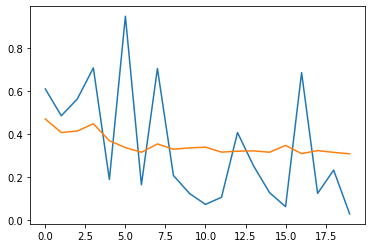

In [228]:
plt.plot(eps,t_loss)
plt.plot(eps,d_loss)
plt.show()

In [248]:
torch.save(net.state_dict(), 'sstcls_{}.dat'.format(ep))